# FSL-105 Video Training with MediaPipe
# ANN Final Project

Jullian A. Bilan & Jan Floyd Vallota
BSCS 3-A AI

This notebook demonstrates how to train a PyTorch model for Filipino Sign Language (FSL) recognition using the FSL-105 video dataset. We will use MediaPipe to extract hand landmarks from video frames and train an LSTM model on the temporal sequences.

In [1]:
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import mediapipe as mp
import zipfile
from tqdm import tqdm
import matplotlib.pyplot as plt
import os


# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [2]:
import torch
print(f"Is CUDA available? {torch.cuda.is_available()}")
print(f"Device Name: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'None'}")

Is CUDA available? True
Device Name: NVIDIA GeForce RTX 3050 Laptop GPU


In [3]:
# Define paths
DATA_ROOT = r"FSL-105 A dataset for recognizing 105 Filipino sign language videos\FSL-105 A dataset for recognizing 105 Filipino sign language videos"
CLIPS_ZIP = os.path.join(DATA_ROOT, "clips.zip")
CLIPS_DIR = os.path.join(DATA_ROOT, "clips")
TRAIN_CSV = os.path.join(DATA_ROOT, "train.csv")
TEST_CSV = os.path.join(DATA_ROOT, "test.csv")
LABELS_CSV = os.path.join(DATA_ROOT, "labels.csv")

# Unzip clips if not already done
if not os.path.exists(CLIPS_DIR):
    print("Unzipping clips...")
    with zipfile.ZipFile(CLIPS_ZIP, 'r') as zip_ref:
        zip_ref.extractall(DATA_ROOT)
    print("Unzipping complete.")
else:
    print("Clips directory already exists.")

Clips directory already exists.


In [4]:
# Load CSVs
train_df = pd.read_csv(TRAIN_CSV)
test_df = pd.read_csv(TEST_CSV)
labels_df = pd.read_csv(LABELS_CSV)

print(f"Train samples: {len(train_df)}")
print(f"Test samples: {len(test_df)}")
print(f"Number of classes: {len(labels_df)}")

# Create label mapping
id_to_label = dict(zip(labels_df['id'], labels_df['label']))
label_to_id = dict(zip(labels_df['label'], labels_df['id']))

print("\nList of Classes:")
for idx, label in id_to_label.items():
    print(f"{idx}: {label}")

Train samples: 1704
Test samples: 426
Number of classes: 105

List of Classes:
0: GOOD MORNING
1: GOOD AFTERNOON
2: GOOD EVENING
3: HELLO
4: HOW ARE YOU
5: IM FINE
6: NICE TO MEET YOU
7: THANK YOU
8: YOURE WELCOME
9: SEE YOU TOMORROW
10: UNDERSTAND
11: DON’T UNDERSTAND
12: KNOW
13: DON’T KNOW
14: NO
15: YES
16: WRONG
17: CORRECT
18: SLOW
19: FAST
20: ONE
21: TWO
22: THREE
23: FOUR
24: FIVE
25: SIX
26: SEVEN
27: EIGHT
28: NINE 
29: TEN
30: JANUARY
31: FEBRUARY
32: MARCH
33: APRIL
34: MAY
35: JUNE
36: JULY
37: AUGUST
38: SEPTEMBER
39: OCTOBER
40: NOVEMBER
41: DECEMBER
42: MONDAY
43: TUESDAY
44: WEDNESDAY
45: THURSDAY
46: FRIDAY
47: SATURDAY
48: SUNDAY
49: TODAY
50: TOMORROW
51: YESTERDAY
52: FATHER
53: MOTHER
54: SON
55: DAUGHTER
56: GRANDFATHER
57: GRANDMOTHER
58: UNCLE
59: AUNTIE
60: COUSIN
61: PARENTS
62: BOY
63: GIRL
64: MAN
65: WOMAN
66: DEAF
67: HARD OF HEARING
68: WEELCHAIR PERSON
69: BLIND
70: DEAF BLIND
71: MARRIED
72: BLUE
73: GREEN
74: RED
75: BROWN
76: BLACK
77: WHITE
78: YEL

In [5]:
# MediaPipe Setup
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(
    static_image_mode=False,
    max_num_hands=2,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
)

def extract_landmarks_from_video(video_path, max_frames=120):
    """
    Extracts hand landmarks from a video file.
    Returns a sequence of shape (seq_len, 126) -> 2 hands * 21 landmarks * 3 coords
    Ensures consistent handedness: Left hand -> 0-63, Right hand -> 63-126
    NORMALIZATION: Normalizes landmarks relative to wrist for better generalization
    """
    cap = cv2.VideoCapture(video_path)
    frames_landmarks = []
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
            
        # Convert to RGB
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = hands.process(frame_rgb)
        
        frame_data = np.zeros(126) # 2 hands * 21 * 3
        
        if results.multi_hand_landmarks and results.multi_handedness:
            for idx, hand_landmarks in enumerate(results.multi_hand_landmarks):
                label = results.multi_handedness[idx].classification[0].label
                
                landmarks = []
                for lm in hand_landmarks.landmark:
                    landmarks.extend([lm.x, lm.y, lm.z])
                
                landmarks = np.array(landmarks)
                
                # CRITICAL: Normalize relative to wrist (landmark 0)
                wrist_x, wrist_y, wrist_z = landmarks[0], landmarks[1], landmarks[2]
                for i in range(0, len(landmarks), 3):
                    landmarks[i] -= wrist_x      # x relative to wrist
                    landmarks[i+1] -= wrist_y    # y relative to wrist
                    landmarks[i+2] -= wrist_z    # z relative to wrist
                
                # Assign to specific slice based on label
                if label == 'Left':
                    frame_data[0:63] = landmarks
                else: # Right
                    frame_data[63:126] = landmarks
                
        frames_landmarks.append(frame_data)
        
        if len(frames_landmarks) >= max_frames:
            break
            
    cap.release()
    
    # Pad or truncate
    if len(frames_landmarks) < max_frames:
        padding = [np.zeros(126) for _ in range(max_frames - len(frames_landmarks))]
        frames_landmarks.extend(padding)
        
    return np.array(frames_landmarks, dtype=np.float32)

# Test on one video
sample_path = os.path.join(DATA_ROOT, train_df.iloc[0]['vid_path'])
print(f"Processing sample: {sample_path}")
landmarks = extract_landmarks_from_video(sample_path)
print(f"Extracted shape: {landmarks.shape}")

Processing sample: FSL-105 A dataset for recognizing 105 Filipino sign language videos\FSL-105 A dataset for recognizing 105 Filipino sign language videos\clips\17\6.MOV
Extracted shape: (120, 126)
Extracted shape: (120, 126)


In [6]:
# Keypoint-level webcam/mediapipe augmentations and motion features
import numpy as np

# --- Keypoint Augmentations (REDUCED aggressiveness to prevent underfitting) ---
def add_gaussian_jitter(seq, sigma=0.01):
    noise = np.random.normal(scale=sigma, size=seq.shape)
    return seq + noise

def random_landmark_dropout(seq, p_drop=0.05):
    seq = seq.copy()
    T, C = seq.shape
    num_landmarks = C // 3
    for t in range(T):
        mask = np.random.rand(num_landmarks) < p_drop
        if mask.any():
            for i, m in enumerate(mask):
                if m:
                    idx = i * 3
                    if t > 0:
                        seq[t, idx:idx+3] = seq[t-1, idx:idx+3]
                    else:
                        seq[t, idx:idx+3] = 0.0
    return seq

def random_frame_dropout(seq, p_frame=0.03):
    seq = seq.copy()
    T, C = seq.shape
    drop_mask = np.random.rand(T) < p_frame
    if not drop_mask.any():
        return seq
    kept_idx = np.where(~drop_mask)[0]
    if len(kept_idx) == 0:
        return seq
    for c in range(C):
        vals = seq[:, c]
        kept_vals = vals[kept_idx]
        seq[:, c] = np.interp(np.arange(T), kept_idx, kept_vals)
    return seq

def temporal_resample_and_jitter(seq, min_ratio=0.85, max_ratio=1.15):
    """Gentler temporal augmentation"""
    T, C = seq.shape
    ratio = np.random.uniform(min_ratio, max_ratio)
    new_T = max(3, int(T * ratio))
    old_idx = np.linspace(0, T - 1, new_T)
    new_seq = np.zeros((new_T, C), dtype=seq.dtype)
    for c in range(C):
        new_seq[:, c] = np.interp(old_idx, np.arange(T), seq[:, c])
    up_idx = np.linspace(0, new_T - 1, T)
    out = np.zeros((T, C), dtype=seq.dtype)
    for c in range(C):
        out[:, c] = np.interp(up_idx, np.arange(new_T), new_seq[:, c])
    return out

def scale_augmentation(seq, scale_range=(0.9, 1.1)):
    """Scale landmarks uniformly - helps with different hand sizes"""
    scale = np.random.uniform(*scale_range)
    return seq * scale

def rotation_augmentation(seq, max_angle=15):
    """Rotate landmarks in 2D plane (x, y) - simulates camera angle differences"""
    angle = np.random.uniform(-max_angle, max_angle) * np.pi / 180
    cos_a, sin_a = np.cos(angle), np.sin(angle)
    seq = seq.copy()
    T, C = seq.shape
    # Rotate each landmark's x, y coordinates
    for i in range(0, C, 3):
        x = seq[:, i].copy()
        y = seq[:, i+1].copy()
        seq[:, i] = cos_a * x - sin_a * y
        seq[:, i+1] = sin_a * x + cos_a * y
    return seq

def time_warp(seq, sigma=0.1):
    """Smooth time warping - simulates speed variations"""
    T, C = seq.shape
    # Create warping path
    warp = np.cumsum(np.random.normal(1, sigma, T))
    warp = warp - warp[0]
    warp = warp / warp[-1] * (T - 1)
    warp = np.clip(warp, 0, T - 1)
    
    out = np.zeros_like(seq)
    for c in range(C):
        out[:, c] = np.interp(np.arange(T), warp, seq[:, c])
    return out

def simulate_webcam_keypoint_aug(seq):
    """Balanced augmentation pipeline - not too aggressive"""
    # Always apply light jitter
    seq = add_gaussian_jitter(seq, sigma=np.random.uniform(0.003, 0.01))
    
    # Randomly apply other augmentations
    if np.random.rand() < 0.3:
        seq = random_landmark_dropout(seq, p_drop=np.random.uniform(0.02, 0.08))
    
    if np.random.rand() < 0.2:
        seq = random_frame_dropout(seq, p_frame=np.random.uniform(0.01, 0.04))
    
    if np.random.rand() < 0.5:
        seq = scale_augmentation(seq, scale_range=(0.9, 1.1))
    
    if np.random.rand() < 0.4:
        seq = rotation_augmentation(seq, max_angle=10)
    
    if np.random.rand() < 0.3:
        seq = time_warp(seq, sigma=0.08)
    
    if np.random.rand() < 0.2:
        seq = temporal_resample_and_jitter(seq, min_ratio=0.9, max_ratio=1.1)
    
    return seq

# --- Motion Features ---
def add_velocity_accel(seq):
    vel = np.vstack([np.zeros((1, seq.shape[1])), seq[1:] - seq[:-1]])
    accel = np.vstack([np.zeros((1, seq.shape[1])), vel[1:] - vel[:-1]])
    return np.concatenate([seq, vel, accel], axis=1)  # (T, 3*C)

def exp_smooth(seq, alpha=0.3):
    """Slightly less smoothing to preserve signal"""
    out = np.zeros_like(seq)
    out[0] = seq[0]
    for t in range(1, len(seq)):
        out[t] = alpha * seq[t] + (1 - alpha) * out[t-1]
    return out

In [7]:
class FSLDataset(Dataset):
    def __init__(self, df, root_dir, augment=False):
        self.df = df
        self.root_dir = root_dir
        self.augment = augment
        self.data = []
        self.labels = []
        
        # Pre-load all data into memory
        print(f"Loading dataset (Augment={augment})...")
        for _, row in tqdm(df.iterrows(), total=len(df)):
            video_path = os.path.join(root_dir, row['vid_path'])
            if os.path.exists(video_path):
                lm = extract_landmarks_from_video(video_path)
                self.data.append(lm)
                self.labels.append(row['id_label'])
            else:
                print(f"Warning: File not found {video_path}")
                
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        landmarks = self.data[idx].copy()  # (T, 126)
        label = self.labels[idx]
        
        # Training-time aggressive augmentations
        if self.augment:
            landmarks = simulate_webcam_keypoint_aug(landmarks)
        
        # Motion features and smoothing
        landmarks = exp_smooth(landmarks, alpha=0.2)
        landmarks = add_velocity_accel(landmarks)  # now (T, 378)
        landmarks = exp_smooth(landmarks, alpha=0.1)
        
        return torch.FloatTensor(landmarks), torch.tensor(label, dtype=torch.long)

# Create datasets
print("Creating Training Dataset...")
train_dataset = FSLDataset(train_df, DATA_ROOT, augment=True)
print("Creating Test Dataset...")
test_dataset = FSLDataset(test_df, DATA_ROOT, augment=False)

# DataLoaders with num_workers for faster loading
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

Creating Training Dataset...
Loading dataset (Augment=True)...


100%|██████████| 1704/1704 [2:18:00<00:00,  4.86s/it]


Creating Test Dataset...
Loading dataset (Augment=False)...


100%|██████████| 426/426 [23:38<00:00,  3.33s/it]



In [8]:
class LandmarkLSTM(nn.Module):
    def __init__(self, input_size=378, hidden_size=512, num_layers=2, num_classes=105, dropout=0.5):
        super(LandmarkLSTM, self).__init__()
        
        # Simpler but effective embedding with LayerNorm for stability
        self.embedding = nn.Sequential(
            nn.Linear(input_size, 384),
            nn.LayerNorm(384),
            nn.GELU(),
            nn.Dropout(dropout * 0.4),
            nn.Linear(384, 384),
            nn.LayerNorm(384),
            nn.GELU(),
            nn.Dropout(dropout * 0.4)
        )
        
        # Bidirectional LSTM - reduced size for less overfitting
        self.lstm = nn.LSTM(
            384, hidden_size, num_layers, 
            batch_first=True, 
            dropout=dropout if num_layers > 1 else 0, 
            bidirectional=True
        )
        
        # Layer norm after LSTM
        self.lstm_norm = nn.LayerNorm(hidden_size * 2)
        
        # Multi-head attention with learnable temperature
        self.attention_query = nn.Linear(hidden_size * 2, 128)
        self.attention_key = nn.Linear(hidden_size * 2, 128)
        self.temperature = nn.Parameter(torch.ones(1) * 0.1)
        
        # Simpler classifier - less prone to overfitting
        self.fc = nn.Sequential(
            nn.Linear(hidden_size * 2, 384),
            nn.LayerNorm(384),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(384, num_classes)
        )
        
        # Initialize weights properly
        self._init_weights()
        
    def _init_weights(self):
        for name, param in self.named_parameters():
            if 'weight' in name and param.dim() >= 2:
                nn.init.xavier_uniform_(param)
            elif 'bias' in name:
                nn.init.zeros_(param)
        
    def forward(self, x):
        batch_size, seq_len, features = x.size()
        
        # Embed each frame
        x = x.reshape(batch_size * seq_len, features)
        x = self.embedding(x)
        x = x.reshape(batch_size, seq_len, -1)
        
        # LSTM with residual-like structure
        lstm_out, _ = self.lstm(x)
        lstm_out = self.lstm_norm(lstm_out)
        
        # Scaled dot-product attention
        Q = self.attention_query(lstm_out)  # (batch, seq, 128)
        K = self.attention_key(lstm_out)    # (batch, seq, 128)
        
        # Attention scores with learnable temperature
        attn_scores = torch.bmm(Q, K.transpose(1, 2)) / (128 ** 0.5)  # (batch, seq, seq)
        attn_scores = attn_scores * torch.exp(self.temperature)
        
        # Self-attention pooling
        attn_weights = torch.softmax(attn_scores.mean(dim=2, keepdim=True), dim=1)  # (batch, seq, 1)
        attended = torch.sum(attn_weights * lstm_out, dim=1)  # (batch, hidden*2)
        
        logits = self.fc(attended)
        return logits, attended

# Create model with updated architecture
model = LandmarkLSTM(num_classes=len(labels_df), dropout=0.5).to(device)
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")

LandmarkLSTM(
  (embedding): Sequential(
    (0): Linear(in_features=378, out_features=384, bias=True)
    (1): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
    (2): GELU(approximate='none')
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=384, out_features=384, bias=True)
    (5): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
    (6): GELU(approximate='none')
    (7): Dropout(p=0.2, inplace=False)
  )
  (lstm): LSTM(384, 512, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (lstm_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (attention_query): Linear(in_features=1024, out_features=128, bias=True)
  (attention_key): Linear(in_features=1024, out_features=128, bias=True)
  (fc): Sequential(
    (0): Linear(in_features=1024, out_features=384, bias=True)
    (1): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
    (2): GELU(approximate='none')
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=384,

Training with: Mixup=True, Focal Loss, SWA starting at epoch 100
Total batches per epoch: 54
✓ New best model saved! Acc: 1.17%
✓ New best model saved! Acc: 1.17%
✓ New best model saved! Acc: 6.34%
✓ New best model saved! Acc: 6.34%
✓ New best model saved! Acc: 9.86%
✓ New best model saved! Acc: 9.86%
✓ New best model saved! Acc: 13.38%
✓ New best model saved! Acc: 13.38%
✓ New best model saved! Acc: 17.37%
Epoch [5/200] Loss: 4.2401 | Train: 13.19% | Test: 17.37% | Best: 17.37% | LR: 0.000181
✓ New best model saved! Acc: 17.37%
Epoch [5/200] Loss: 4.2401 | Train: 13.19% | Test: 17.37% | Best: 17.37% | LR: 0.000181
✓ New best model saved! Acc: 23.71%
✓ New best model saved! Acc: 23.71%
✓ New best model saved! Acc: 26.29%
✓ New best model saved! Acc: 26.29%
✓ New best model saved! Acc: 27.23%
✓ New best model saved! Acc: 27.23%
Epoch [10/200] Loss: 3.5837 | Train: 21.80% | Test: 21.60% | Best: 27.23% | LR: 0.000521
Epoch [10/200] Loss: 3.5837 | Train: 21.80% | Test: 21.60% | Best: 27.23

c:\Users\julli\ANN-finalProject\.venv-tf\Lib\site-packages\torch\nn\modules\rnn.py:1123: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\RNN.cpp:1410.)
  result = _VF.lstm(


✓ New best SWA model saved! Acc: 55.40%
✓ New best SWA model saved! Acc: 56.10%
✓ New best SWA model saved! Acc: 56.10%
✓ New best SWA model saved! Acc: 57.98%
✓ New best SWA model saved! Acc: 57.98%
Epoch [105/200] Loss: 1.8670 | Train: 63.34% | Test: 55.16% | SWA: 57.51% | Best: 57.98% | LR: 0.000343
Epoch [105/200] Loss: 1.8670 | Train: 63.34% | Test: 55.16% | SWA: 57.51% | Best: 57.98% | LR: 0.000343
✓ New best model saved! Acc: 58.69%
✓ New best model saved! Acc: 58.69%
Epoch [110/200] Loss: 1.7005 | Train: 68.27% | Test: 57.98% | SWA: 57.75% | Best: 58.69% | LR: 0.000100
Epoch [110/200] Loss: 1.7005 | Train: 68.27% | Test: 57.98% | SWA: 57.75% | Best: 58.69% | LR: 0.000100
✓ New best model saved! Acc: 58.92%
✓ New best model saved! Acc: 58.92%
Epoch [115/200] Loss: 1.7910 | Train: 67.85% | Test: 58.92% | SWA: 58.22% | Best: 58.92% | LR: 0.000100
Epoch [115/200] Loss: 1.7910 | Train: 67.85% | Test: 58.92% | SWA: 58.22% | Best: 58.92% | LR: 0.000100
✓ New best model saved! Acc: 59.

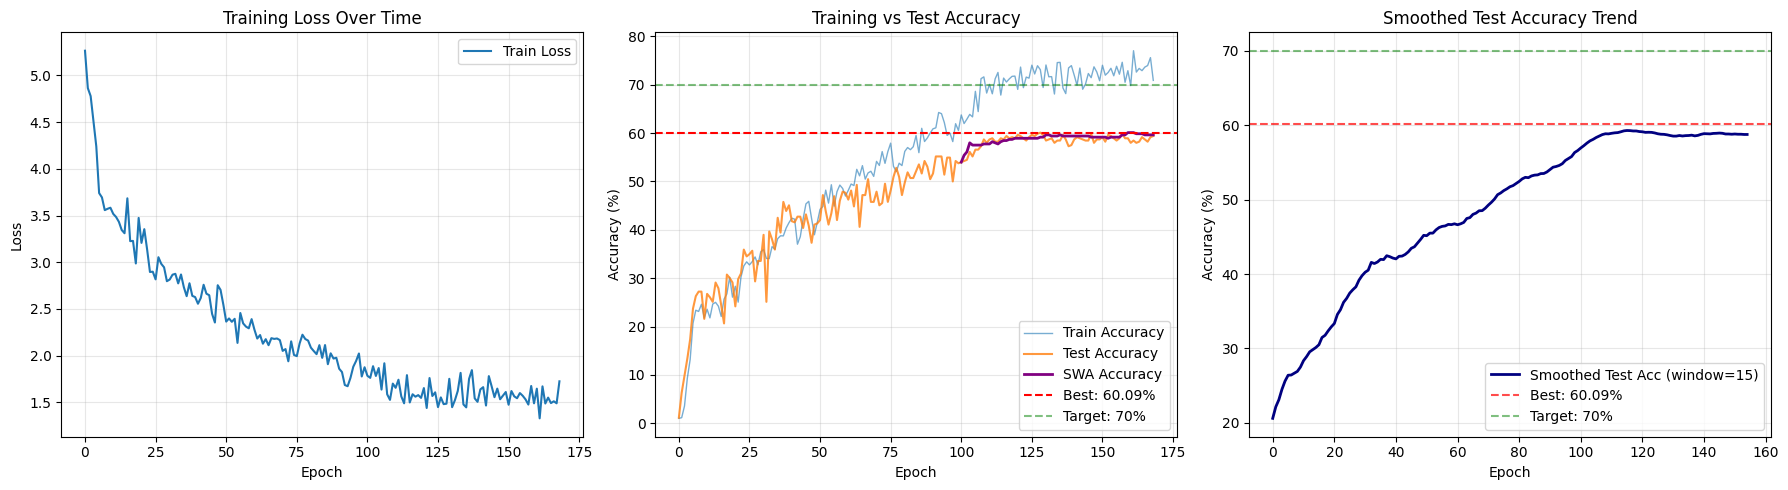

In [9]:
# Advanced training with multiple techniques to break 60% plateau
from torch.nn import functional as F
from torch.optim.swa_utils import AveragedModel, SWALR
import copy

# ============ MIXUP AUGMENTATION ============
def mixup_data(x, y, alpha=0.4):
    """Mixup augmentation - proven to improve generalization"""
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# ============ FOCAL LOSS for hard examples ============
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None, label_smoothing=0.1):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.label_smoothing = label_smoothing
        
    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', label_smoothing=self.label_smoothing)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss
        return focal_loss.mean()

# ============ LOSSES ============
criterion = FocalLoss(gamma=2.0, label_smoothing=0.1)  # Focal loss focuses on hard examples
triplet_loss_fn = nn.TripletMarginLoss(margin=0.5, p=2)

# ============ OPTIMIZER with different LR for different parts ============
embedding_params = list(model.embedding.parameters())
lstm_params = list(model.lstm.parameters()) + list(model.lstm_norm.parameters())
attention_params = list(model.attention_query.parameters()) + list(model.attention_key.parameters()) + [model.temperature]
fc_params = list(model.fc.parameters())

optimizer = optim.AdamW([
    {'params': embedding_params, 'lr': 0.0003, 'weight_decay': 0.01},
    {'params': lstm_params, 'lr': 0.0005, 'weight_decay': 0.001},
    {'params': attention_params, 'lr': 0.001, 'weight_decay': 0.0001},
    {'params': fc_params, 'lr': 0.0005, 'weight_decay': 0.01}
], betas=(0.9, 0.999))

# OneCycleLR - often better than cosine for breaking plateaus
num_epochs = 200
steps_per_epoch = len(train_loader)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, 
    max_lr=[0.001, 0.002, 0.003, 0.002],  # Peak LR for each param group
    epochs=num_epochs,
    steps_per_epoch=steps_per_epoch,
    pct_start=0.1,  # Warmup for 10% of training
    anneal_strategy='cos',
    div_factor=25,
    final_div_factor=1000
)

# Stochastic Weight Averaging for better generalization
swa_model = AveragedModel(model)
swa_start = 100  # Start SWA after epoch 100
swa_scheduler = SWALR(optimizer, swa_lr=0.0001)

alpha_triplet = 0.3  # Reduced triplet weight
use_mixup = True
mixup_alpha = 0.3

train_losses = []
train_accuracies = []
test_accuracies = []
swa_accuracies = []

best_acc = 0.0
patience_counter = 0
patience_limit = 40

# Simple in-batch triplet miner
def sample_triplets(embeddings, labels):
    anchors, positives, negatives = [], [], []
    labels_np = labels.cpu().numpy()
    for i in range(len(labels_np)):
        anchor_label = labels_np[i]
        pos_indices = np.where(labels_np == anchor_label)[0]
        neg_indices = np.where(labels_np != anchor_label)[0]
        if len(pos_indices) <= 1 or len(neg_indices) == 0:
            continue
        pos_idx = np.random.choice(pos_indices[pos_indices != i])
        neg_idx = np.random.choice(neg_indices)
        anchors.append(embeddings[i])
        positives.append(embeddings[pos_idx])
        negatives.append(embeddings[neg_idx])
    if len(anchors) == 0:
        return None
    return torch.stack(anchors), torch.stack(positives), torch.stack(negatives)

print(f"Training with: Mixup={use_mixup}, Focal Loss, SWA starting at epoch {swa_start}")
print(f"Total batches per epoch: {steps_per_epoch}")
print("="*70)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        # Apply mixup with probability
        if use_mixup and np.random.rand() < 0.5:
            inputs_mixed, labels_a, labels_b, lam = mixup_data(inputs, labels, mixup_alpha)
            logits, embeds = model(inputs_mixed)
            ce_loss = mixup_criterion(criterion, logits, labels_a, labels_b, lam)
            # For accuracy, use original predictions
            _, predicted = torch.max(logits.data, 1)
            correct += (lam * (predicted == labels_a).float() + (1-lam) * (predicted == labels_b).float()).sum().item()
        else:
            logits, embeds = model(inputs)
            ce_loss = criterion(logits, labels)
            _, predicted = torch.max(logits.data, 1)
            correct += (predicted == labels).sum().item()
        
        # Triplet loss (only on non-mixed batches)
        if not use_mixup or np.random.rand() > 0.5:
            triplet_tensors = sample_triplets(embeds, labels)
            if triplet_tensors is not None:
                a, p, n = triplet_tensors
                triplet_loss = triplet_loss_fn(a, p, n)
            else:
                triplet_loss = torch.tensor(0.0, device=device)
        else:
            triplet_loss = torch.tensor(0.0, device=device)
        
        loss = ce_loss + alpha_triplet * triplet_loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        # Step OneCycleLR per batch
        if epoch < swa_start:
            scheduler.step()
        
        running_loss += loss.item()
        total += labels.size(0)
    
    epoch_loss = running_loss/len(train_loader)
    train_losses.append(epoch_loss)
    train_acc = 100*correct/total
    train_accuracies.append(train_acc)
    
    # Update SWA model after swa_start
    if epoch >= swa_start:
        swa_model.update_parameters(model)
        swa_scheduler.step()
    
    # Validation with regular model
    model.eval()
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            logits, _ = model(inputs)
            _, predicted = torch.max(logits.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
    
    test_acc = 100*test_correct/test_total
    test_accuracies.append(test_acc)
    
    # Also evaluate SWA model if active
    swa_acc = 0.0
    if epoch >= swa_start:
        swa_model.eval()
        swa_correct = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                logits, _ = swa_model(inputs)
                _, predicted = torch.max(logits.data, 1)
                swa_correct += (predicted == labels).sum().item()
        swa_acc = 100*swa_correct/test_total
        swa_accuracies.append(swa_acc)
    
    # Save best model
    current_best = max(test_acc, swa_acc) if epoch >= swa_start else test_acc
    if current_best > best_acc:
        best_acc = current_best
        if swa_acc > test_acc and epoch >= swa_start:
            torch.save(swa_model.module.state_dict(), 'fsl_video_model_v4_best.pth')
            print(f"✓ New best SWA model saved! Acc: {swa_acc:.2f}%")
        else:
            torch.save(model.state_dict(), 'fsl_video_model_v4_best.pth')
            print(f"✓ New best model saved! Acc: {test_acc:.2f}%")
        patience_counter = 0
    else:
        patience_counter += 1
    
    if (epoch + 1) % 5 == 0:
        lr_str = f"{optimizer.param_groups[0]['lr']:.6f}"
        swa_str = f" | SWA: {swa_acc:.2f}%" if epoch >= swa_start else ""
        print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {epoch_loss:.4f} | Train: {train_acc:.2f}% | Test: {test_acc:.2f}%{swa_str} | Best: {best_acc:.2f}% | LR: {lr_str}")
    
    if patience_counter >= patience_limit:
        print(f"\nEarly stopping triggered. No improvement for {patience_limit} epochs.")
        break

# Final SWA batch norm update
if len(swa_accuracies) > 0:
    print("\nUpdating SWA batch normalization...")
    torch.optim.swa_utils.update_bn(train_loader, swa_model, device=device)
    
    # Final SWA evaluation
    swa_model.eval()
    swa_correct = 0
    swa_total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            logits, _ = swa_model(inputs)
            _, predicted = torch.max(logits.data, 1)
            swa_total += labels.size(0)
            swa_correct += (predicted == labels).sum().item()
    final_swa_acc = 100*swa_correct/swa_total
    print(f"Final SWA Accuracy: {final_swa_acc:.2f}%")
    
    if final_swa_acc > best_acc:
        best_acc = final_swa_acc
        torch.save(swa_model.module.state_dict(), 'fsl_video_model_v4_best.pth')
        print(f"✓ SWA model is best! Saved with {final_swa_acc:.2f}%")

print(f"\n{'='*70}")
print(f"Training Complete! Best Test Accuracy: {best_acc:.2f}%")
print(f"{'='*70}")

# Save final models
torch.save(model.state_dict(), 'fsl_video_model_v4_final.pth')
if len(swa_accuracies) > 0:
    torch.save(swa_model.module.state_dict(), 'fsl_video_model_v4_swa.pth')
print("Models saved as fsl_video_model_v4_*.pth")

# Enhanced Plotting
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss', linewidth=1.5)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(train_accuracies, label='Train Accuracy', alpha=0.6, linewidth=1)
plt.plot(test_accuracies, label='Test Accuracy', alpha=0.8, linewidth=1.5)
if len(swa_accuracies) > 0:
    swa_x = list(range(swa_start, swa_start + len(swa_accuracies)))
    plt.plot(swa_x, swa_accuracies, label='SWA Accuracy', linewidth=2, color='purple')
plt.axhline(y=best_acc, color='r', linestyle='--', label=f'Best: {best_acc:.2f}%')
plt.axhline(y=70, color='g', linestyle='--', alpha=0.5, label='Target: 70%')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training vs Test Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
window = 15
if len(test_accuracies) >= window:
    smoothed = np.convolve(test_accuracies, np.ones(window)/window, mode='valid')
    plt.plot(smoothed, label=f'Smoothed Test Acc (window={window})', linewidth=2, color='navy')
    plt.axhline(y=best_acc, color='r', linestyle='--', alpha=0.7, label=f'Best: {best_acc:.2f}%')
    plt.axhline(y=70, color='g', linestyle='--', alpha=0.5, label='Target: 70%')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Smoothed Test Accuracy Trend')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [10]:
# Save an extra copy of the latest model snapshot
torch.save(model.state_dict(), 'fsl_video_model_v4_latest.pth')
print("Model saved as fsl_video_model_v4_latest.pth")

# Print summary of changes made
print("\n" + "="*70)
print("V4 Model Changes Summary:")
print("="*70)
print("1. Smaller model (512 hidden vs 768) - less overfitting")
print("2. LayerNorm instead of BatchNorm - more stable training")
print("3. GELU activation - smoother gradients")
print("4. Scaled dot-product attention with learnable temperature")
print("5. Focal Loss - focuses on hard examples")
print("6. Mixup augmentation - improves generalization")
print("7. OneCycleLR scheduler - better learning rate scheduling")
print("8. Stochastic Weight Averaging (SWA) - finds flatter minima")
print("9. Reduced augmentation aggressiveness")
print("10. Added rotation and scaling augmentations")
print("="*70)

Model saved as fsl_video_model_v4_latest.pth

V4 Model Changes Summary:
1. Smaller model (512 hidden vs 768) - less overfitting
2. LayerNorm instead of BatchNorm - more stable training
3. GELU activation - smoother gradients
4. Scaled dot-product attention with learnable temperature
5. Focal Loss - focuses on hard examples
6. Mixup augmentation - improves generalization
7. OneCycleLR scheduler - better learning rate scheduling
8. Stochastic Weight Averaging (SWA) - finds flatter minima
9. Reduced augmentation aggressiveness
10. Added rotation and scaling augmentations


In [11]:
# ============================================================================
# COMPREHENSIVE MODEL EVALUATION & VISUALIZATION
# ============================================================================
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.metrics import top_k_accuracy_score
import seaborn as sns

print("="*70)
print("GENERATING COMPREHENSIVE MODEL EVALUATION")
print("="*70)

# Use the best model for evaluation
best_model = model
if len(swa_accuracies) > 0 and max(swa_accuracies) >= best_acc:
    best_model = swa_model.module
    print("Using SWA model for evaluation")
else:
    best_model.load_state_dict(torch.load('fsl_video_model_v4_best.pth'))
    print("Using best checkpoint for evaluation")

best_model.eval()

# Collect all predictions and ground truth
all_preds = []
all_labels = []
all_probs = []
all_embeddings = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Evaluating"):
        inputs, labels = inputs.to(device), labels.to(device)
        logits, embeds = best_model(inputs)
        probs = torch.softmax(logits, dim=1)
        _, predicted = torch.max(logits, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
        all_embeddings.extend(embeds.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)
all_embeddings = np.array(all_embeddings)

# Calculate metrics
accuracy = 100 * np.mean(all_preds == all_labels)
print(f"\nFinal Test Accuracy: {accuracy:.2f}%")

# Top-k accuracy
top3_acc = top_k_accuracy_score(all_labels, all_probs, k=3) * 100
top5_acc = top_k_accuracy_score(all_labels, all_probs, k=5) * 100
print(f"Top-3 Accuracy: {top3_acc:.2f}%")
print(f"Top-5 Accuracy: {top5_acc:.2f}%")

GENERATING COMPREHENSIVE MODEL EVALUATION
Using SWA model for evaluation


Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]c:\Users\julli\ANN-finalProject\.venv-tf\Lib\site-packages\torch\nn\modules\rnn.py:1123: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\RNN.cpp:1410.)
  result = _VF.lstm(
Evaluating:  14%|█▍        | 2/14 [00:00<00:00, 14.15it/s]c:\Users\julli\ANN-finalProject\.venv-tf\Lib\site-packages\torch\nn\modules\rnn.py:1123: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\n


Final Test Accuracy: 59.62%
Top-3 Accuracy: 72.30%
Top-5 Accuracy: 76.53%


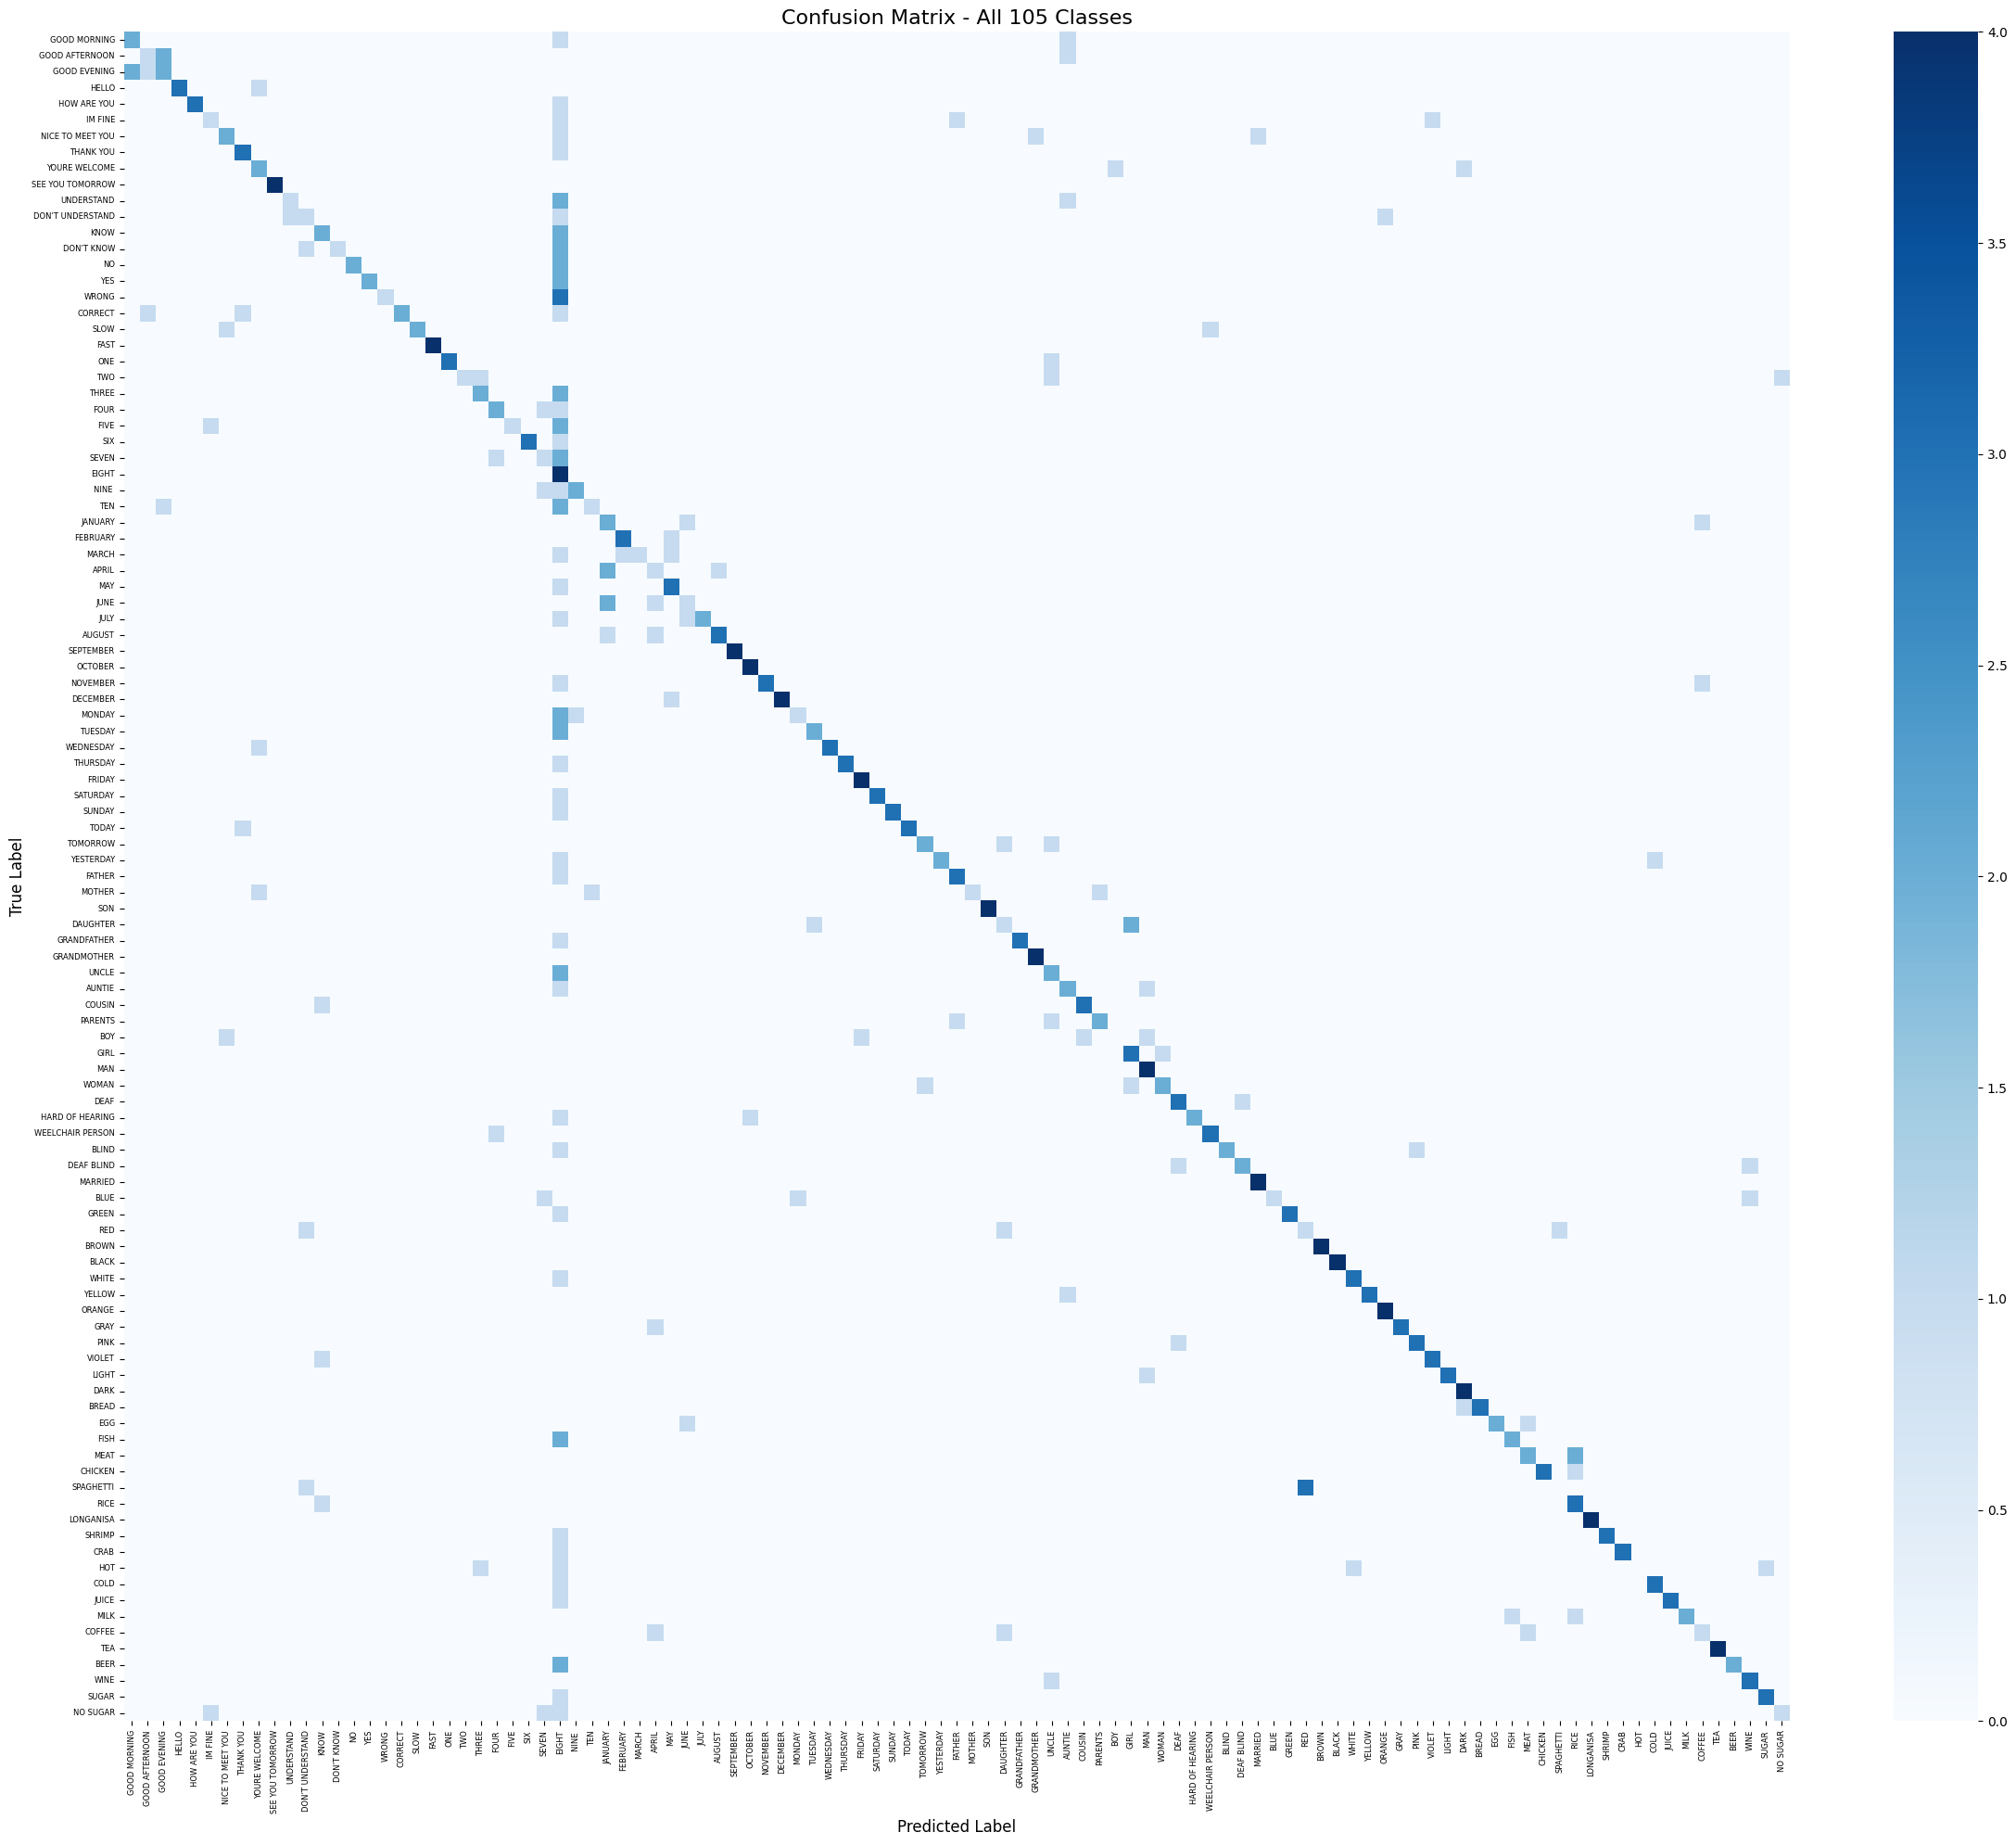

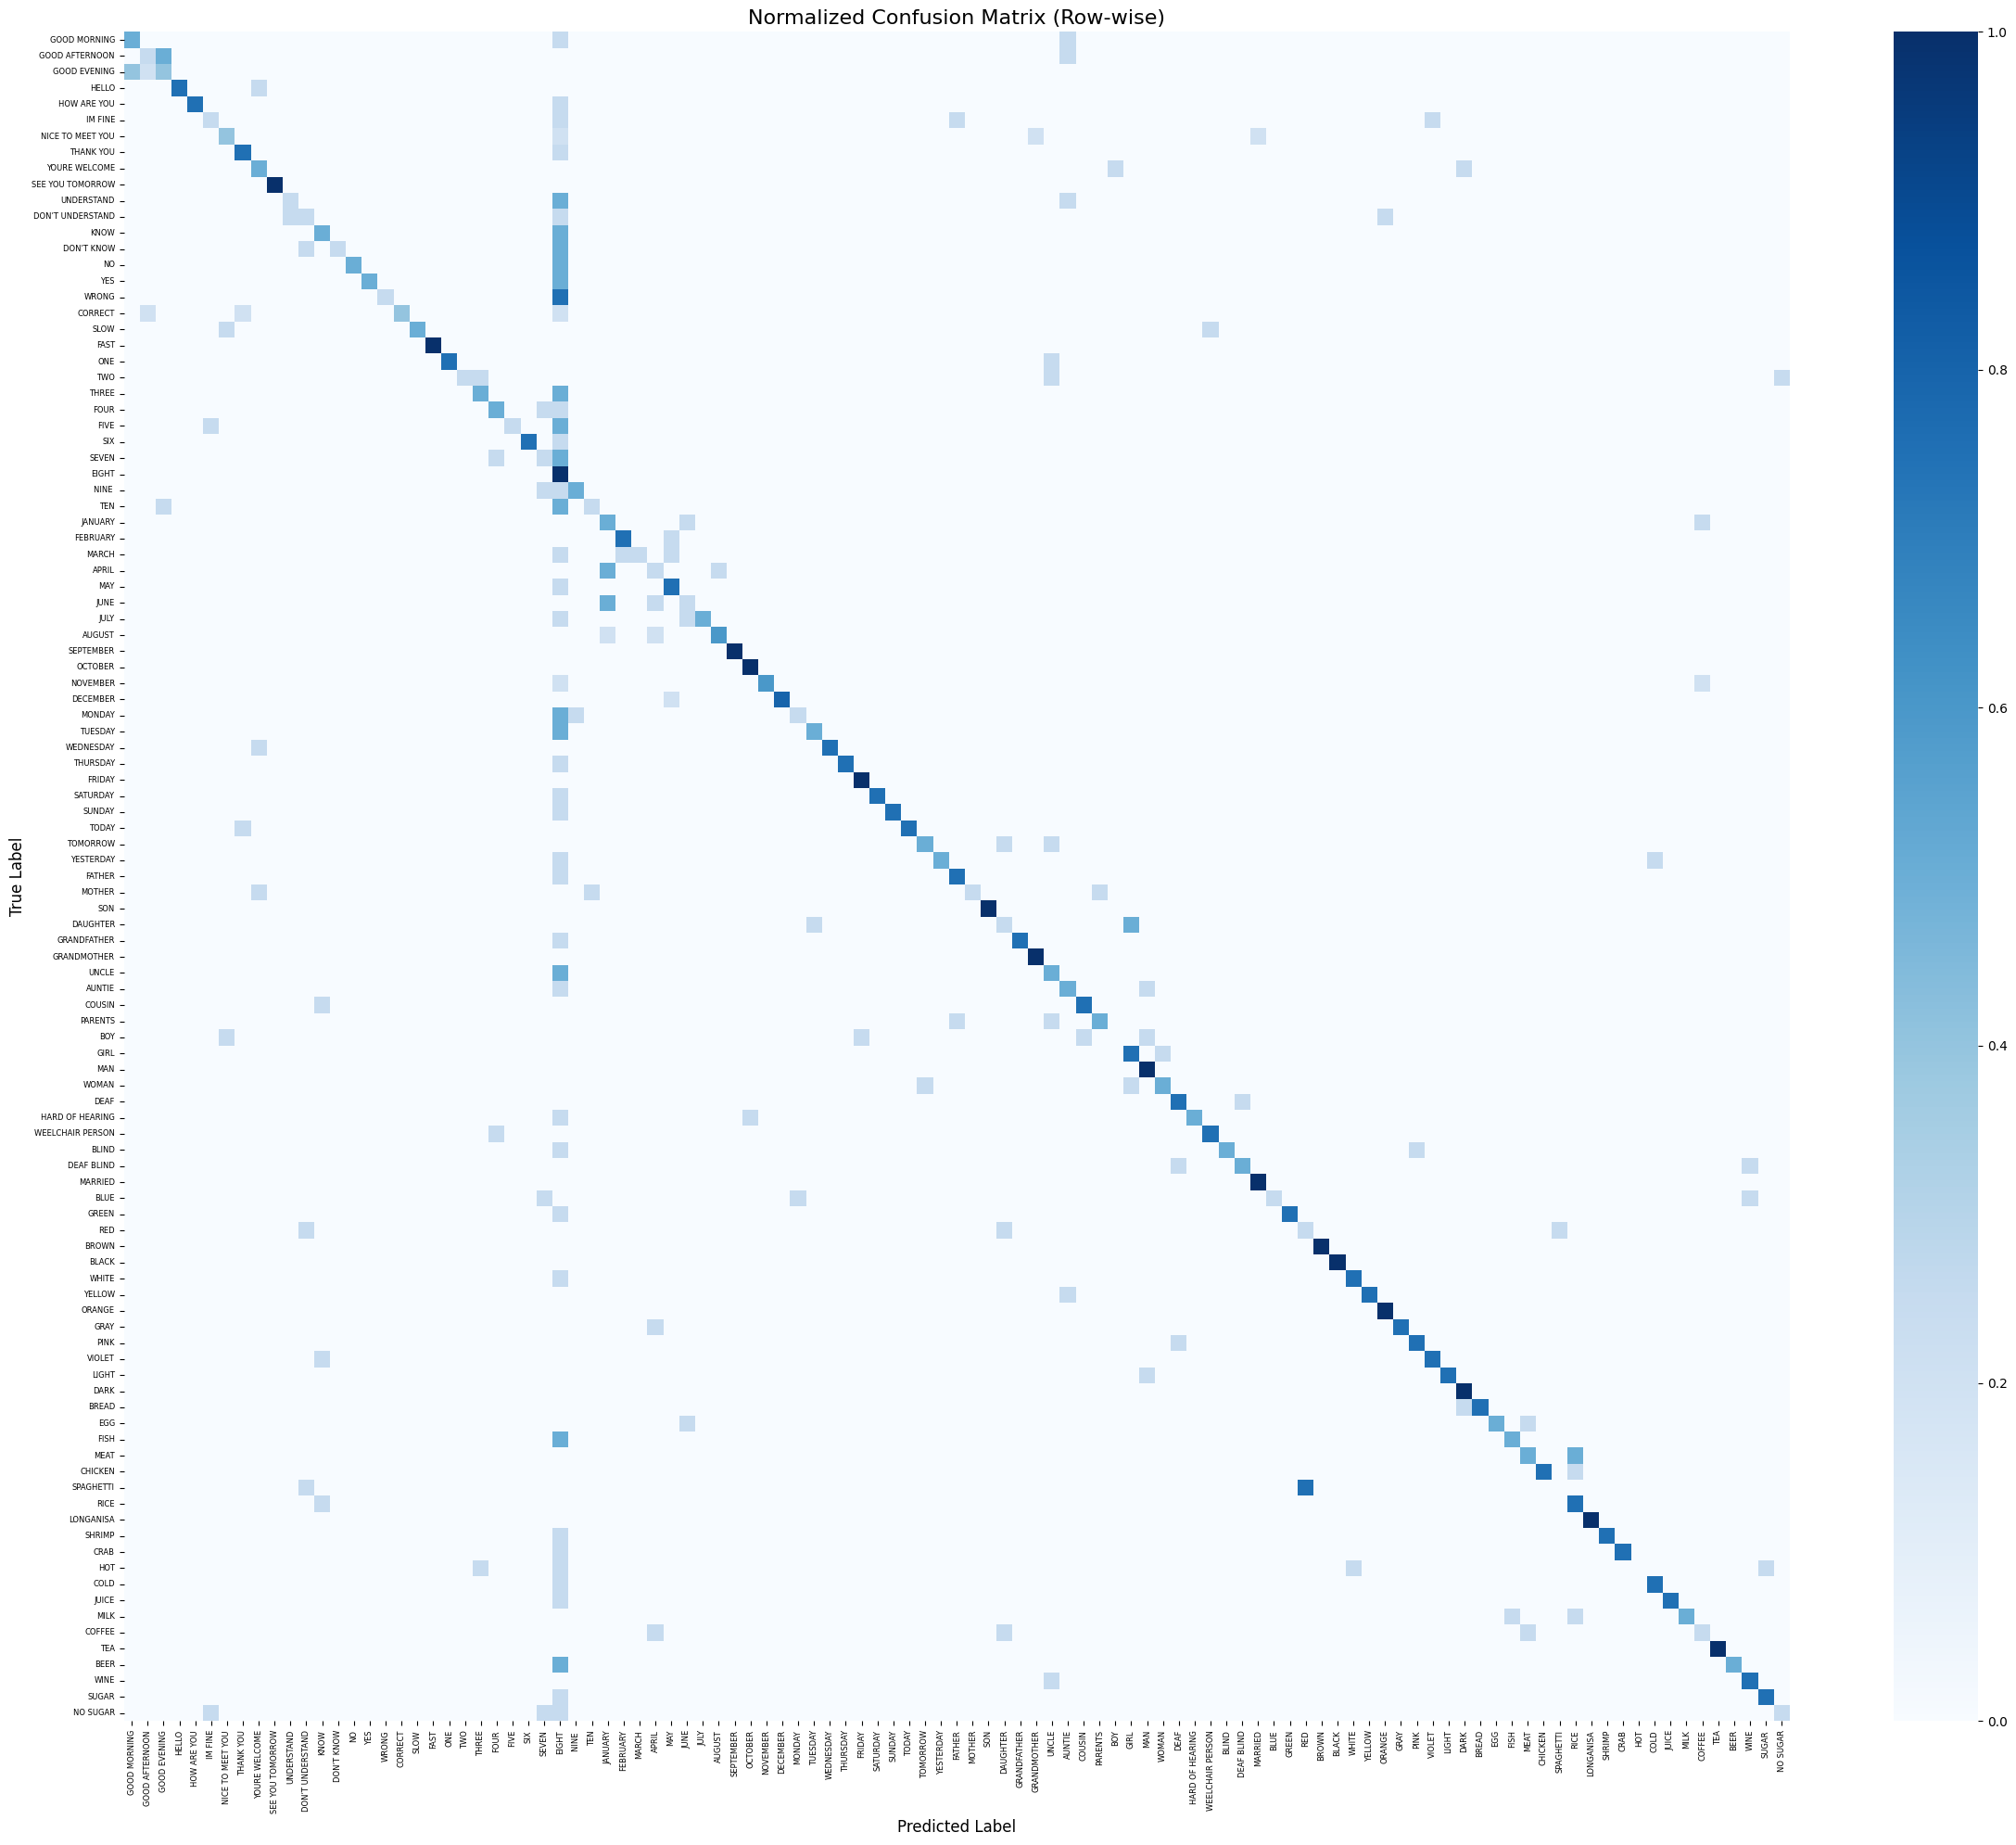

✓ Confusion matrices saved


In [12]:
# ============================================================================
# 1. CONFUSION MATRIX (Full and Simplified)
# ============================================================================

# Get class names
class_names = [id_to_label[i] for i in range(len(id_to_label))]

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Full confusion matrix (might be large for 105 classes)
plt.figure(figsize=(24, 20))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - All 105 Classes', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=90, fontsize=6)
plt.yticks(rotation=0, fontsize=6)
plt.tight_layout()
plt.savefig('confusion_matrix_full.png', dpi=150, bbox_inches='tight')
plt.show()

# Normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_normalized = np.nan_to_num(cm_normalized)  # Handle division by zero

plt.figure(figsize=(24, 20))
sns.heatmap(cm_normalized, annot=False, fmt='.2f', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, vmin=0, vmax=1)
plt.title('Normalized Confusion Matrix (Row-wise)', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=90, fontsize=6)
plt.yticks(rotation=0, fontsize=6)
plt.tight_layout()
plt.savefig('confusion_matrix_normalized.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Confusion matrices saved")

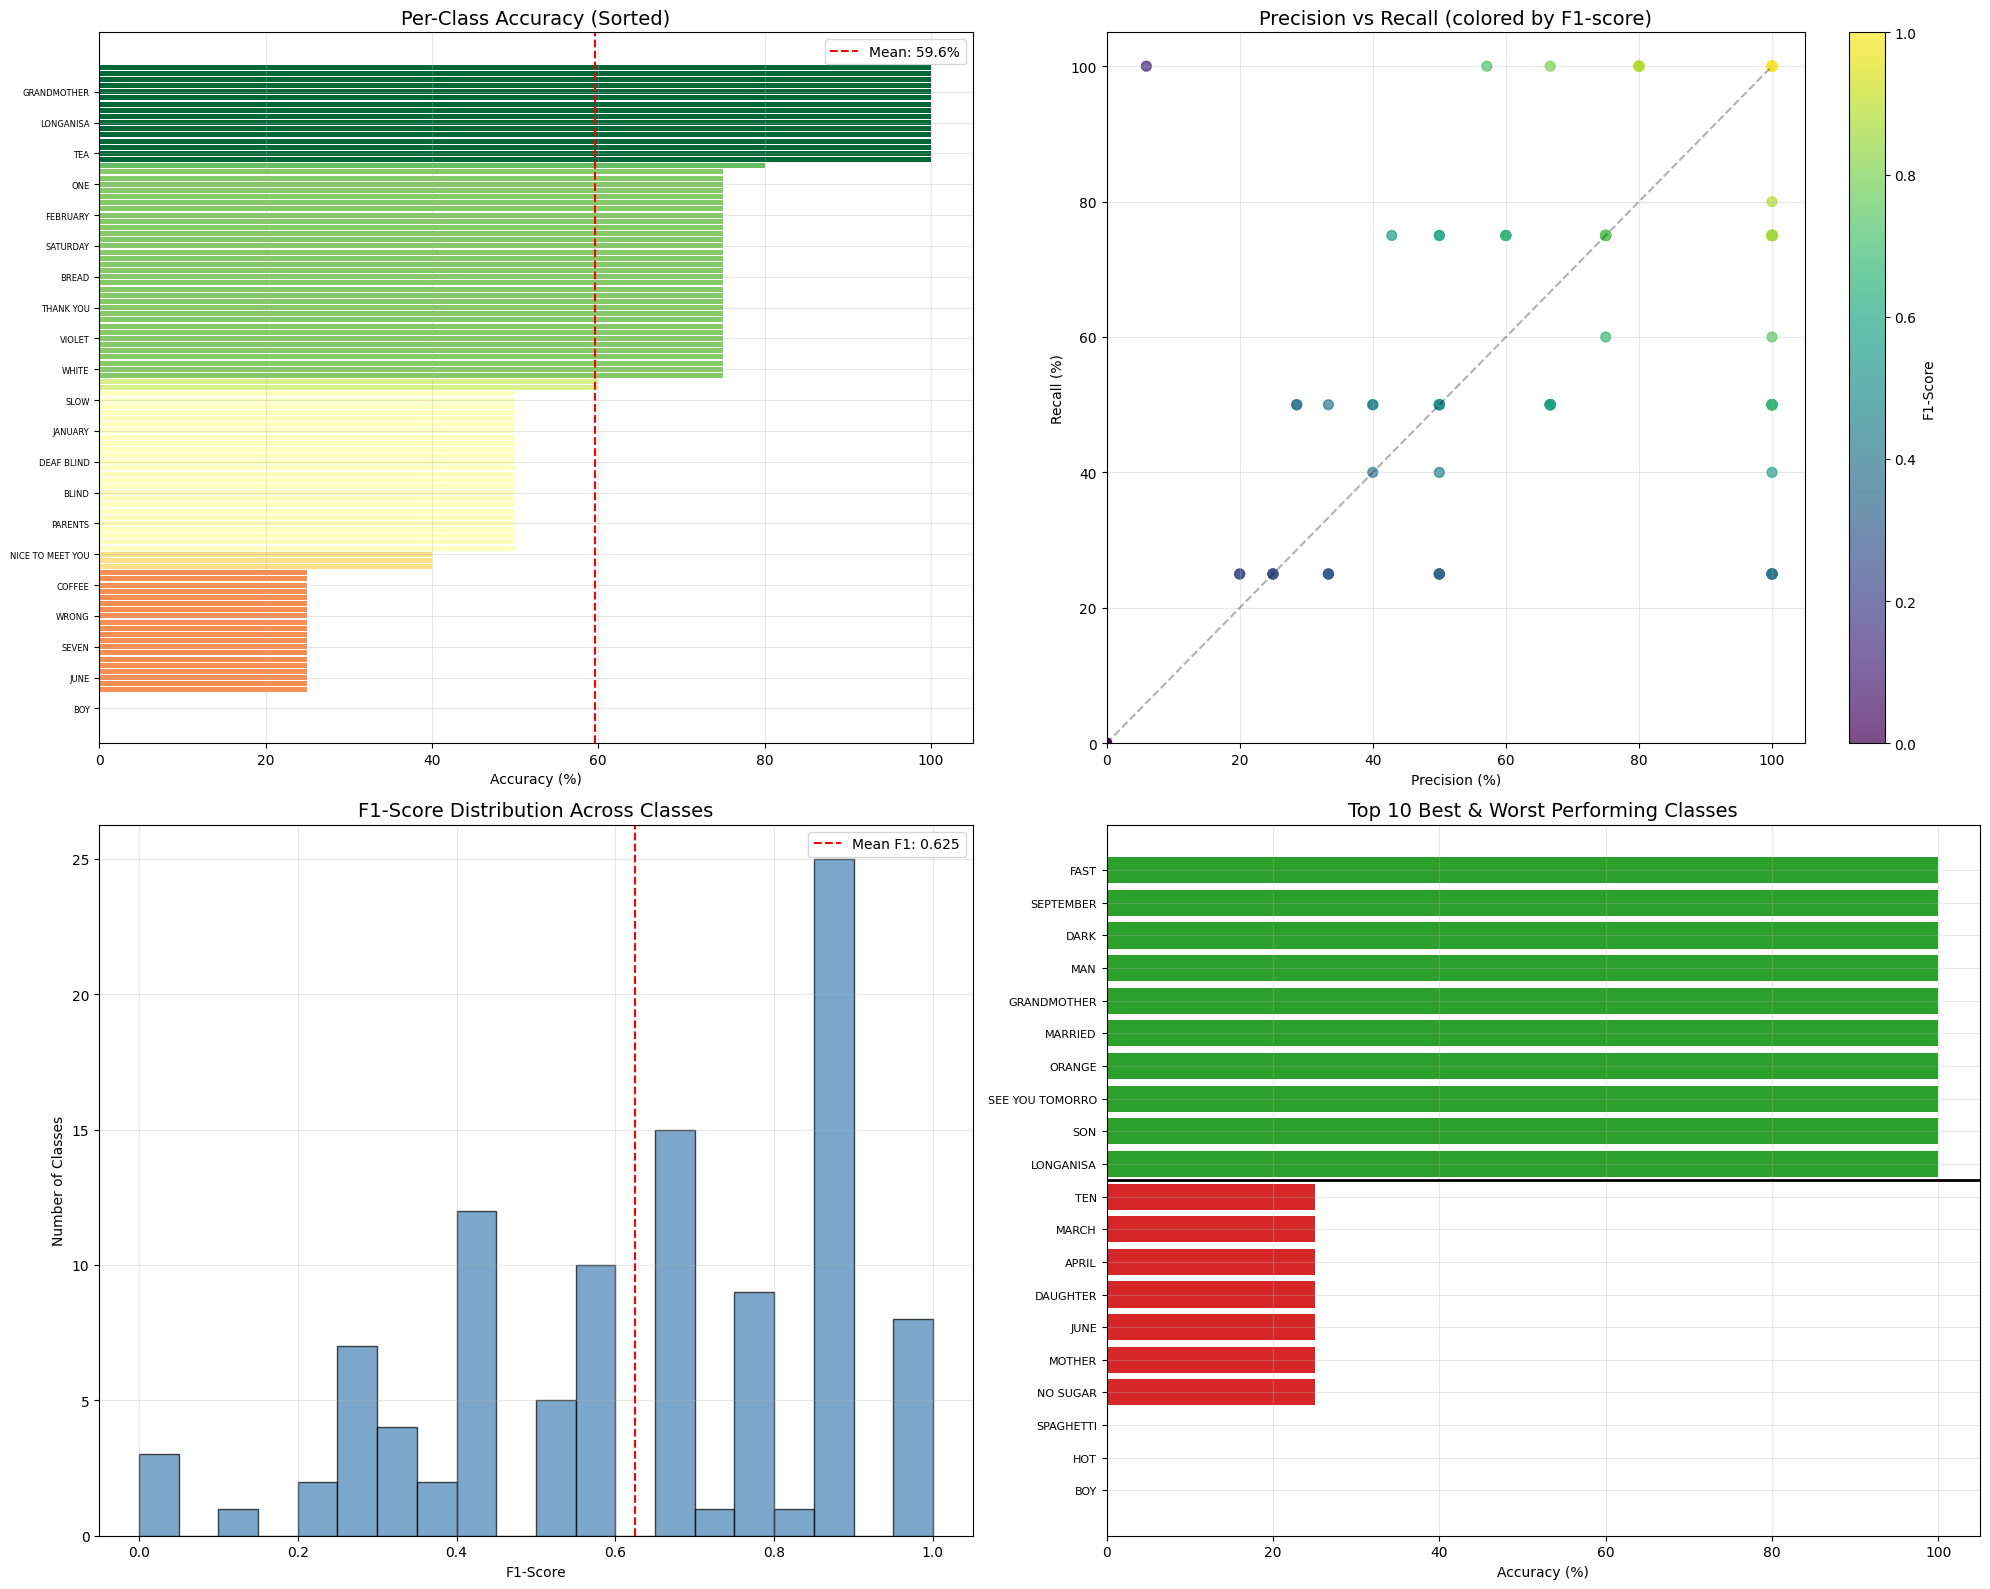


Per-Class Metrics Summary:
  Accuracy - Mean: 59.71%, Std: 26.32%
  Precision - Mean: 72.90%, Std: 29.49%
  Recall - Mean: 59.71%, Std: 26.32%
  F1-Score - Mean: 0.6250, Std: 0.2500

  Best 5 classes: ['GRANDMOTHER', 'MAN', 'DARK', 'SEPTEMBER', 'FAST']
  Worst 5 classes: ['BOY', 'HOT', 'SPAGHETTI', 'NO SUGAR', 'MOTHER']


In [13]:
# ============================================================================
# 2. PER-CLASS ACCURACY, PRECISION, RECALL, F1
# ============================================================================

# Calculate per-class metrics
precision, recall, f1, support = precision_recall_fscore_support(all_labels, all_preds, average=None, zero_division=0)

# Per-class accuracy
per_class_acc = np.zeros(len(class_names))
for i in range(len(class_names)):
    mask = all_labels == i
    if mask.sum() > 0:
        per_class_acc[i] = (all_preds[mask] == i).mean() * 100

# Sort by accuracy for visualization
sorted_idx = np.argsort(per_class_acc)

# Create comprehensive per-class metrics plot
fig, axes = plt.subplots(2, 2, figsize=(20, 16))

# Plot 1: Per-class accuracy (sorted)
ax1 = axes[0, 0]
colors = plt.cm.RdYlGn(per_class_acc[sorted_idx] / 100)
bars = ax1.barh(range(len(sorted_idx)), per_class_acc[sorted_idx], color=colors)
ax1.set_yticks(range(0, len(sorted_idx), 5))
ax1.set_yticklabels([class_names[sorted_idx[i]] for i in range(0, len(sorted_idx), 5)], fontsize=6)
ax1.set_xlabel('Accuracy (%)')
ax1.set_title('Per-Class Accuracy (Sorted)', fontsize=14)
ax1.axvline(x=accuracy, color='red', linestyle='--', label=f'Mean: {accuracy:.1f}%')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Precision vs Recall scatter
ax2 = axes[0, 1]
scatter = ax2.scatter(precision * 100, recall * 100, c=f1, cmap='viridis', s=50, alpha=0.7)
ax2.set_xlabel('Precision (%)')
ax2.set_ylabel('Recall (%)')
ax2.set_title('Precision vs Recall (colored by F1-score)', fontsize=14)
ax2.plot([0, 100], [0, 100], 'k--', alpha=0.3)
plt.colorbar(scatter, ax=ax2, label='F1-Score')
ax2.grid(True, alpha=0.3)
ax2.set_xlim(0, 105)
ax2.set_ylim(0, 105)

# Plot 3: F1-score distribution
ax3 = axes[1, 0]
ax3.hist(f1, bins=20, edgecolor='black', alpha=0.7, color='steelblue')
ax3.axvline(x=f1.mean(), color='red', linestyle='--', label=f'Mean F1: {f1.mean():.3f}')
ax3.set_xlabel('F1-Score')
ax3.set_ylabel('Number of Classes')
ax3.set_title('F1-Score Distribution Across Classes', fontsize=14)
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Top 10 best and worst performing classes
ax4 = axes[1, 1]
n_show = 10
worst_idx = sorted_idx[:n_show]
best_idx = sorted_idx[-n_show:]
combined_idx = np.concatenate([worst_idx, best_idx])
combined_names = [class_names[i][:15] for i in combined_idx]
combined_acc = per_class_acc[combined_idx]
colors = ['#d62728'] * n_show + ['#2ca02c'] * n_show
ax4.barh(range(len(combined_idx)), combined_acc, color=colors)
ax4.set_yticks(range(len(combined_idx)))
ax4.set_yticklabels(combined_names, fontsize=8)
ax4.axhline(y=n_show - 0.5, color='black', linestyle='-', linewidth=2)
ax4.set_xlabel('Accuracy (%)')
ax4.set_title(f'Top {n_show} Best & Worst Performing Classes', fontsize=14)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('per_class_metrics.png', dpi=150, bbox_inches='tight')
plt.show()

# Print statistics
print(f"\nPer-Class Metrics Summary:")
print(f"  Accuracy - Mean: {per_class_acc.mean():.2f}%, Std: {per_class_acc.std():.2f}%")
print(f"  Precision - Mean: {precision.mean()*100:.2f}%, Std: {precision.std()*100:.2f}%")
print(f"  Recall - Mean: {recall.mean()*100:.2f}%, Std: {recall.std()*100:.2f}%")
print(f"  F1-Score - Mean: {f1.mean():.4f}, Std: {f1.std():.4f}")
print(f"\n  Best 5 classes: {[class_names[i] for i in sorted_idx[-5:]]}")
print(f"  Worst 5 classes: {[class_names[i] for i in sorted_idx[:5]]}")

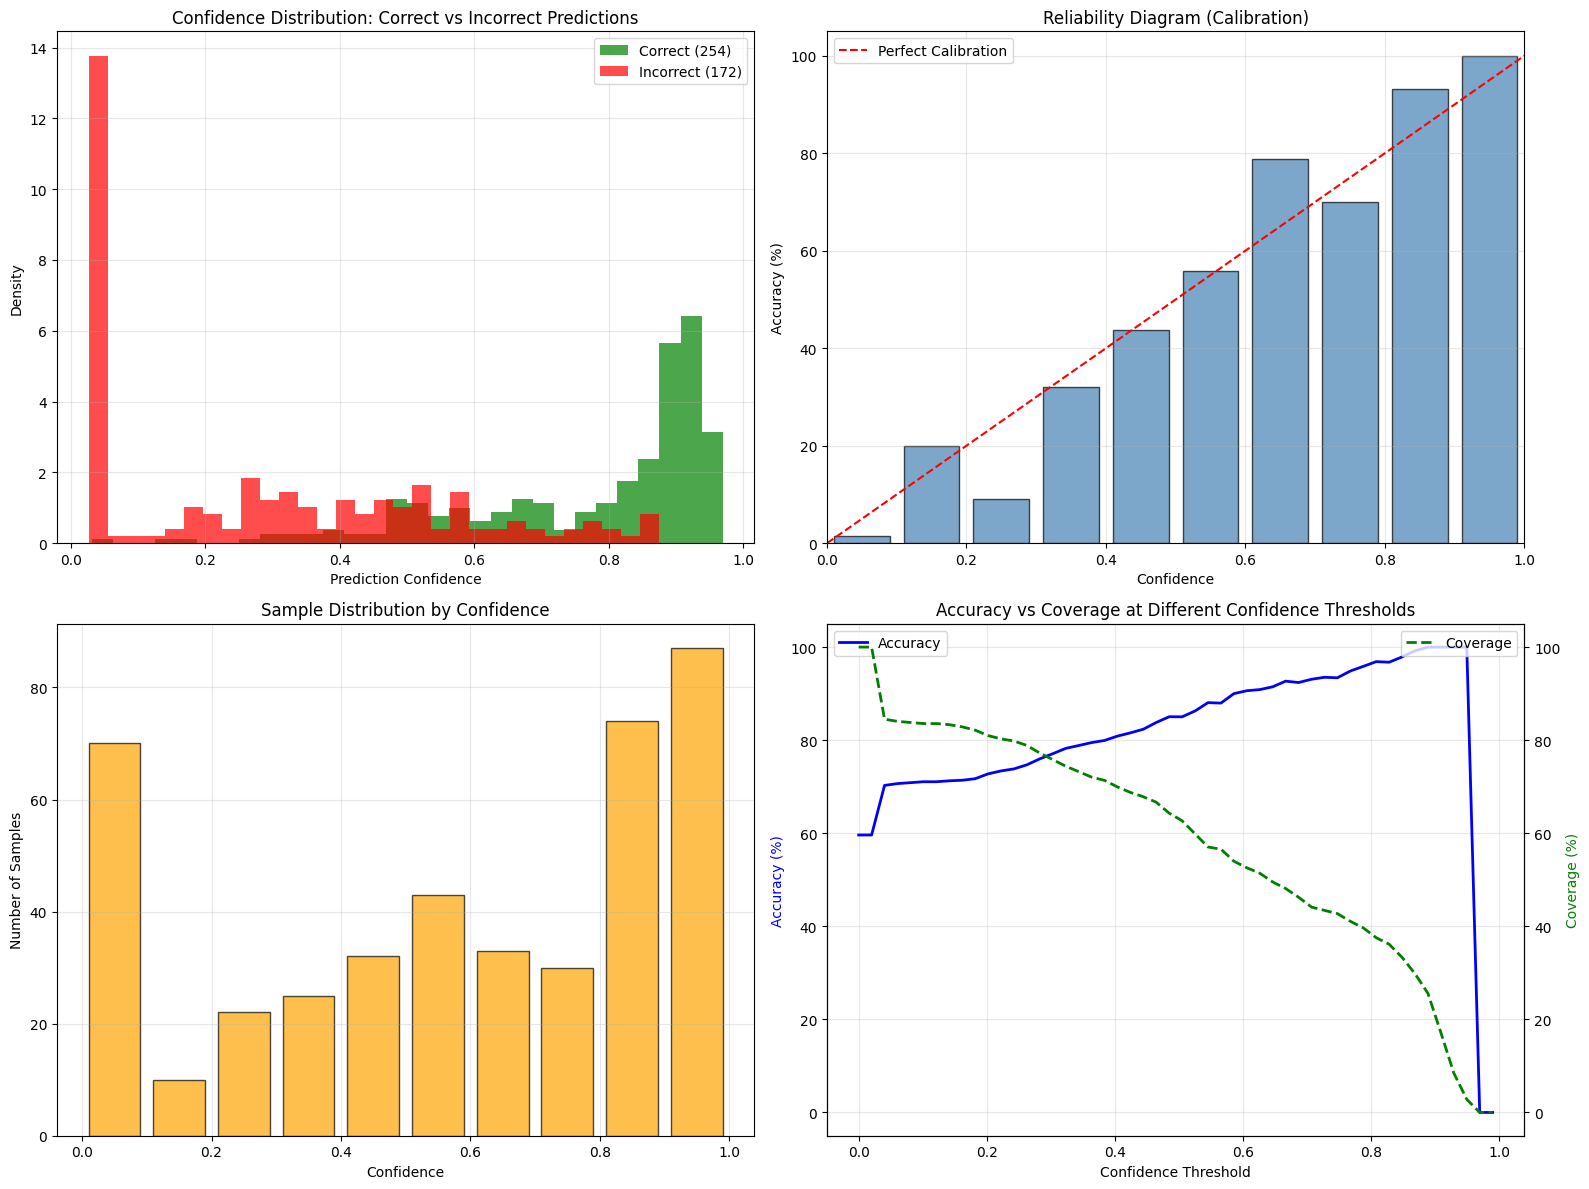


Expected Calibration Error (ECE): 0.0575


In [14]:
# ============================================================================
# 3. CONFIDENCE ANALYSIS
# ============================================================================

# Get confidence scores for predictions
pred_confidences = np.max(all_probs, axis=1)
correct_mask = all_preds == all_labels
incorrect_mask = ~correct_mask

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Confidence distribution for correct vs incorrect
ax1 = axes[0, 0]
ax1.hist(pred_confidences[correct_mask], bins=30, alpha=0.7, label=f'Correct ({correct_mask.sum()})', color='green', density=True)
ax1.hist(pred_confidences[incorrect_mask], bins=30, alpha=0.7, label=f'Incorrect ({incorrect_mask.sum()})', color='red', density=True)
ax1.set_xlabel('Prediction Confidence')
ax1.set_ylabel('Density')
ax1.set_title('Confidence Distribution: Correct vs Incorrect Predictions', fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Accuracy vs Confidence bins
ax2 = axes[0, 1]
confidence_bins = np.linspace(0, 1, 11)
bin_accuracies = []
bin_counts = []
bin_centers = []
for i in range(len(confidence_bins) - 1):
    mask = (pred_confidences >= confidence_bins[i]) & (pred_confidences < confidence_bins[i+1])
    if mask.sum() > 0:
        bin_acc = (all_preds[mask] == all_labels[mask]).mean() * 100
        bin_accuracies.append(bin_acc)
        bin_counts.append(mask.sum())
        bin_centers.append((confidence_bins[i] + confidence_bins[i+1]) / 2)

ax2.bar(bin_centers, bin_accuracies, width=0.08, alpha=0.7, color='steelblue', edgecolor='black')
ax2.plot([0, 1], [0, 100], 'r--', label='Perfect Calibration')
ax2.set_xlabel('Confidence')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Reliability Diagram (Calibration)', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 105)

# Plot 3: Sample count per confidence bin
ax3 = axes[1, 0]
ax3.bar(bin_centers, bin_counts, width=0.08, alpha=0.7, color='orange', edgecolor='black')
ax3.set_xlabel('Confidence')
ax3.set_ylabel('Number of Samples')
ax3.set_title('Sample Distribution by Confidence', fontsize=12)
ax3.grid(True, alpha=0.3)

# Plot 4: Cumulative accuracy at different confidence thresholds
ax4 = axes[1, 1]
thresholds = np.linspace(0, 0.99, 50)
cum_acc = []
cum_coverage = []
for thresh in thresholds:
    mask = pred_confidences >= thresh
    if mask.sum() > 0:
        cum_acc.append((all_preds[mask] == all_labels[mask]).mean() * 100)
        cum_coverage.append(mask.sum() / len(all_preds) * 100)
    else:
        cum_acc.append(0)
        cum_coverage.append(0)

ax4_twin = ax4.twinx()
ax4.plot(thresholds, cum_acc, 'b-', linewidth=2, label='Accuracy')
ax4_twin.plot(thresholds, cum_coverage, 'g--', linewidth=2, label='Coverage')
ax4.set_xlabel('Confidence Threshold')
ax4.set_ylabel('Accuracy (%)', color='blue')
ax4_twin.set_ylabel('Coverage (%)', color='green')
ax4.set_title('Accuracy vs Coverage at Different Confidence Thresholds', fontsize=12)
ax4.legend(loc='upper left')
ax4_twin.legend(loc='upper right')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('confidence_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

# Expected Calibration Error (ECE)
ece = 0
for i in range(len(bin_centers)):
    if bin_counts[i] > 0:
        ece += (bin_counts[i] / len(all_preds)) * abs(bin_accuracies[i]/100 - bin_centers[i])
print(f"\nExpected Calibration Error (ECE): {ece:.4f}")


Top 20 Most Confused Class Pairs:
--------------------------------------------------------------------------------
True Class                Predicted As                 Count       Rate
--------------------------------------------------------------------------------
WRONG                     EIGHT                            3      75.0%
SPAGHETTI                 RED                              3      75.0%
GOOD AFTERNOON            GOOD EVENING                     2      50.0%
GOOD EVENING              GOOD MORNING                     2      40.0%
UNDERSTAND                EIGHT                            2      50.0%
KNOW                      EIGHT                            2      50.0%
DON’T KNOW                EIGHT                            2      50.0%
NO                        EIGHT                            2      50.0%
YES                       EIGHT                            2      50.0%
THREE                     EIGHT                            2      50.0%
FIVE       

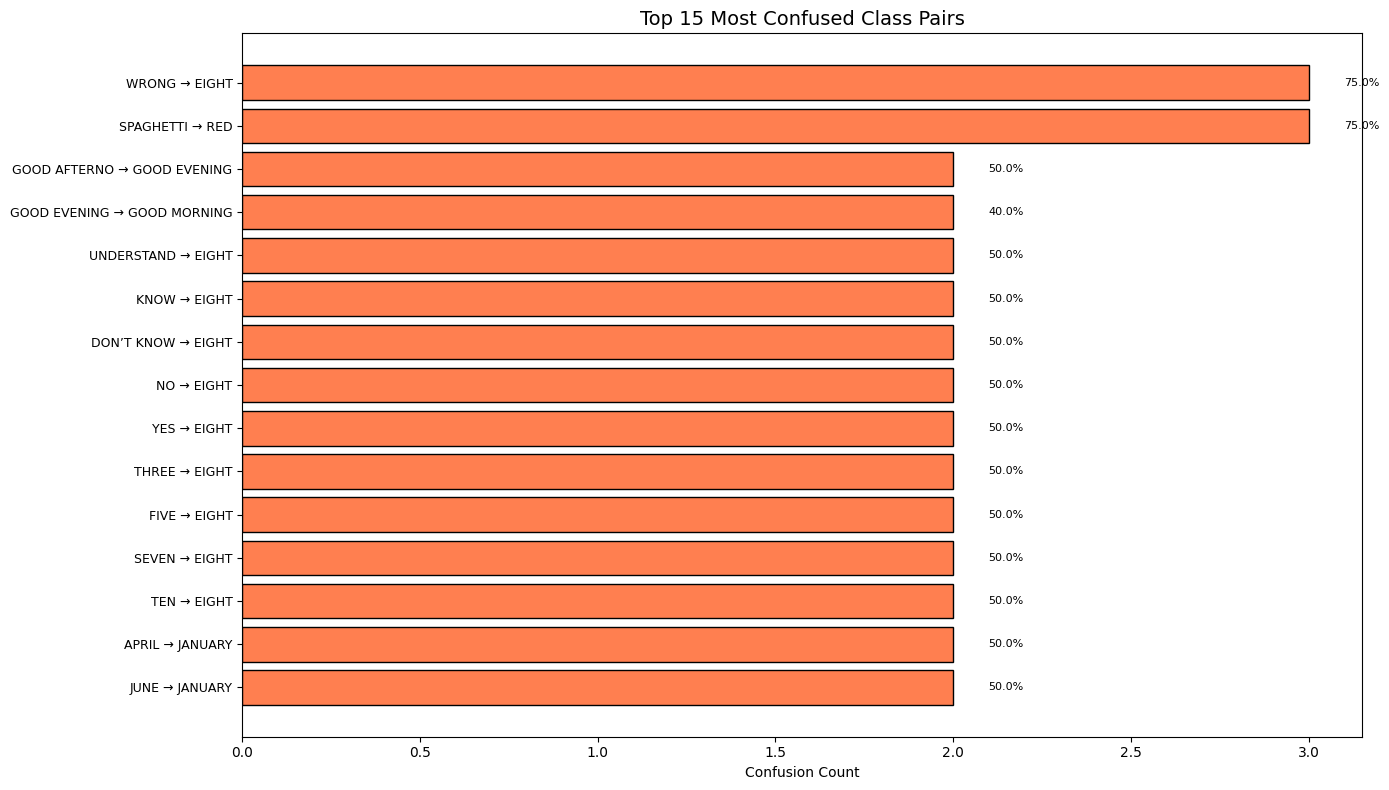

In [15]:
# ============================================================================
# 4. MOST CONFUSED CLASS PAIRS
# ============================================================================

# Find most confused pairs
confusion_pairs = []
for i in range(len(class_names)):
    for j in range(len(class_names)):
        if i != j and cm[i, j] > 0:
            confusion_pairs.append({
                'true': class_names[i],
                'pred': class_names[j],
                'count': cm[i, j],
                'true_total': cm[i].sum(),
                'confusion_rate': cm[i, j] / cm[i].sum() * 100 if cm[i].sum() > 0 else 0
            })

# Sort by confusion count
confusion_pairs.sort(key=lambda x: x['count'], reverse=True)

# Display top 20 most confused pairs
print("\nTop 20 Most Confused Class Pairs:")
print("-" * 80)
print(f"{'True Class':<25} {'Predicted As':<25} {'Count':>8} {'Rate':>10}")
print("-" * 80)
for pair in confusion_pairs[:20]:
    print(f"{pair['true']:<25} {pair['pred']:<25} {pair['count']:>8} {pair['confusion_rate']:>9.1f}%")

# Visualize top confused pairs
fig, ax = plt.subplots(figsize=(14, 8))
top_n = 15
pair_labels = [f"{p['true'][:12]} → {p['pred'][:12]}" for p in confusion_pairs[:top_n]]
pair_counts = [p['count'] for p in confusion_pairs[:top_n]]
pair_rates = [p['confusion_rate'] for p in confusion_pairs[:top_n]]

bars = ax.barh(range(top_n), pair_counts, color='coral', edgecolor='black')
ax.set_yticks(range(top_n))
ax.set_yticklabels(pair_labels, fontsize=9)
ax.set_xlabel('Confusion Count')
ax.set_title(f'Top {top_n} Most Confused Class Pairs', fontsize=14)
ax.invert_yaxis()

# Add rate annotations
for i, (count, rate) in enumerate(zip(pair_counts, pair_rates)):
    ax.text(count + 0.1, i, f'{rate:.1f}%', va='center', fontsize=8)

plt.tight_layout()
plt.savefig('confused_pairs.png', dpi=150, bbox_inches='tight')
plt.show()

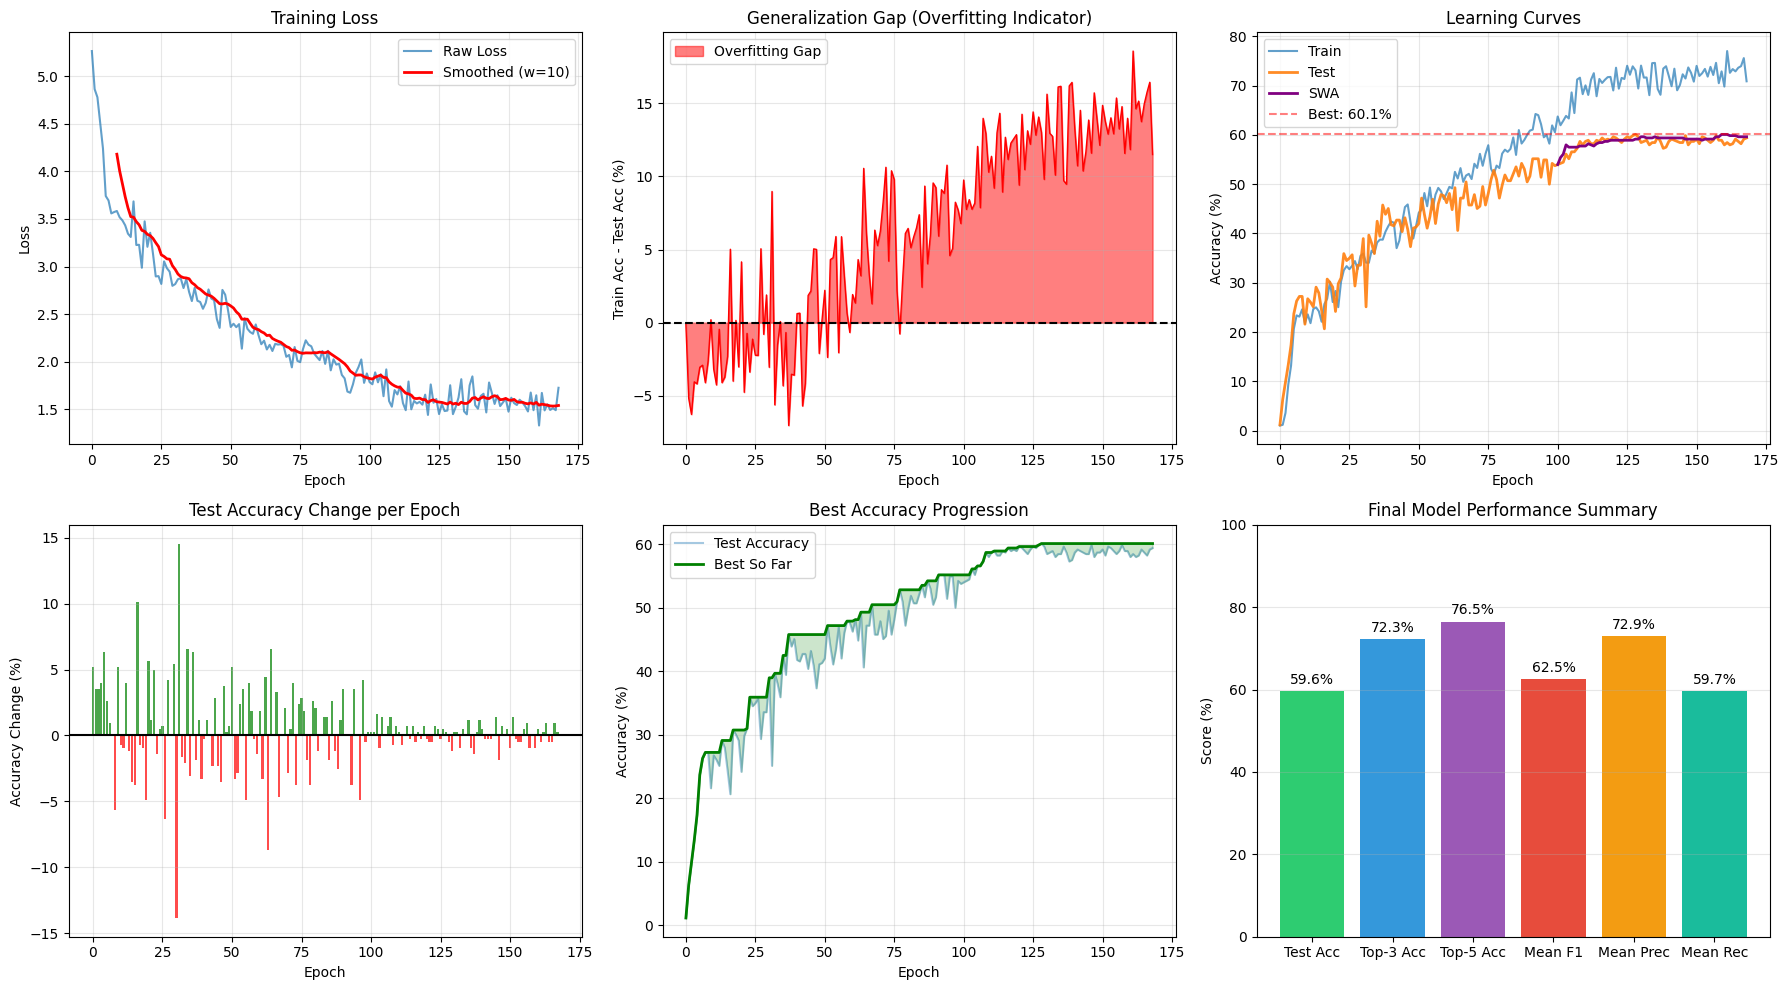

In [16]:
# ============================================================================
# 6. TRAINING DYNAMICS ANALYSIS
# ============================================================================

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Plot 1: Loss curve with trend
ax1 = axes[0, 0]
ax1.plot(train_losses, alpha=0.7, label='Raw Loss')
window = 10
if len(train_losses) >= window:
    smoothed_loss = np.convolve(train_losses, np.ones(window)/window, mode='valid')
    ax1.plot(range(window-1, len(train_losses)), smoothed_loss, 'r-', linewidth=2, label=f'Smoothed (w={window})')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss', fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Train vs Test accuracy gap (overfitting indicator)
ax2 = axes[0, 1]
gap = np.array(train_accuracies) - np.array(test_accuracies)
ax2.fill_between(range(len(gap)), gap, alpha=0.5, color='red', label='Overfitting Gap')
ax2.plot(gap, 'r-', linewidth=1)
ax2.axhline(y=0, color='black', linestyle='--')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Train Acc - Test Acc (%)')
ax2.set_title('Generalization Gap (Overfitting Indicator)', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Learning curves
ax3 = axes[0, 2]
ax3.plot(train_accuracies, label='Train', alpha=0.7)
ax3.plot(test_accuracies, label='Test', alpha=0.9, linewidth=2)
if len(swa_accuracies) > 0:
    swa_x = list(range(swa_start, swa_start + len(swa_accuracies)))
    ax3.plot(swa_x, swa_accuracies, label='SWA', linewidth=2, color='purple')
ax3.axhline(y=best_acc, color='r', linestyle='--', alpha=0.5, label=f'Best: {best_acc:.1f}%')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Accuracy (%)')
ax3.set_title('Learning Curves', fontsize=12)
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Accuracy improvement rate
ax4 = axes[1, 0]
if len(test_accuracies) > 1:
    improvement = np.diff(test_accuracies)
    ax4.bar(range(len(improvement)), improvement, alpha=0.7, 
            color=['green' if x > 0 else 'red' for x in improvement])
    ax4.axhline(y=0, color='black', linestyle='-')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Accuracy Change (%)')
    ax4.set_title('Test Accuracy Change per Epoch', fontsize=12)
    ax4.grid(True, alpha=0.3)

# Plot 5: Best accuracy over time (cumulative max)
ax5 = axes[1, 1]
cummax_acc = np.maximum.accumulate(test_accuracies)
ax5.plot(test_accuracies, alpha=0.4, label='Test Accuracy')
ax5.plot(cummax_acc, 'g-', linewidth=2, label='Best So Far')
ax5.fill_between(range(len(cummax_acc)), test_accuracies, cummax_acc, alpha=0.2, color='green')
ax5.set_xlabel('Epoch')
ax5.set_ylabel('Accuracy (%)')
ax5.set_title('Best Accuracy Progression', fontsize=12)
ax5.legend()
ax5.grid(True, alpha=0.3)

# Plot 6: Final epoch distribution
ax6 = axes[1, 2]
# Show key metrics as a summary bar
metrics = {
    'Test Acc': accuracy,
    'Top-3 Acc': top3_acc,
    'Top-5 Acc': top5_acc,
    'Mean F1': f1.mean() * 100,
    'Mean Prec': precision.mean() * 100,
    'Mean Rec': recall.mean() * 100
}
bars = ax6.bar(metrics.keys(), metrics.values(), color=['#2ecc71', '#3498db', '#9b59b6', '#e74c3c', '#f39c12', '#1abc9c'])
ax6.set_ylabel('Score (%)')
ax6.set_title('Final Model Performance Summary', fontsize=12)
ax6.set_ylim(0, 100)
for bar, val in zip(bars, metrics.values()):
    ax6.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, f'{val:.1f}%', 
             ha='center', va='bottom', fontsize=10)
ax6.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('training_dynamics.png', dpi=150, bbox_inches='tight')
plt.show()


FULL CLASSIFICATION REPORT
                  precision    recall  f1-score   support

    GOOD MORNING       0.50      0.50      0.50         4
  GOOD AFTERNOON       0.33      0.25      0.29         4
    GOOD EVENING       0.40      0.40      0.40         5
           HELLO       1.00      0.75      0.86         4
     HOW ARE YOU       1.00      0.75      0.86         4
         IM FINE       0.33      0.25      0.29         4
NICE TO MEET YOU       0.50      0.40      0.44         5
       THANK YOU       0.60      0.75      0.67         4
   YOURE WELCOME       0.40      0.50      0.44         4
SEE YOU TOMORROW       1.00      1.00      1.00         4
      UNDERSTAND       0.50      0.25      0.33         4
DON’T UNDERSTAND       0.25      0.25      0.25         4
            KNOW       0.40      0.50      0.44         4
      DON’T KNOW       1.00      0.25      0.40         4
              NO       1.00      0.50      0.67         4
             YES       1.00      0.50      

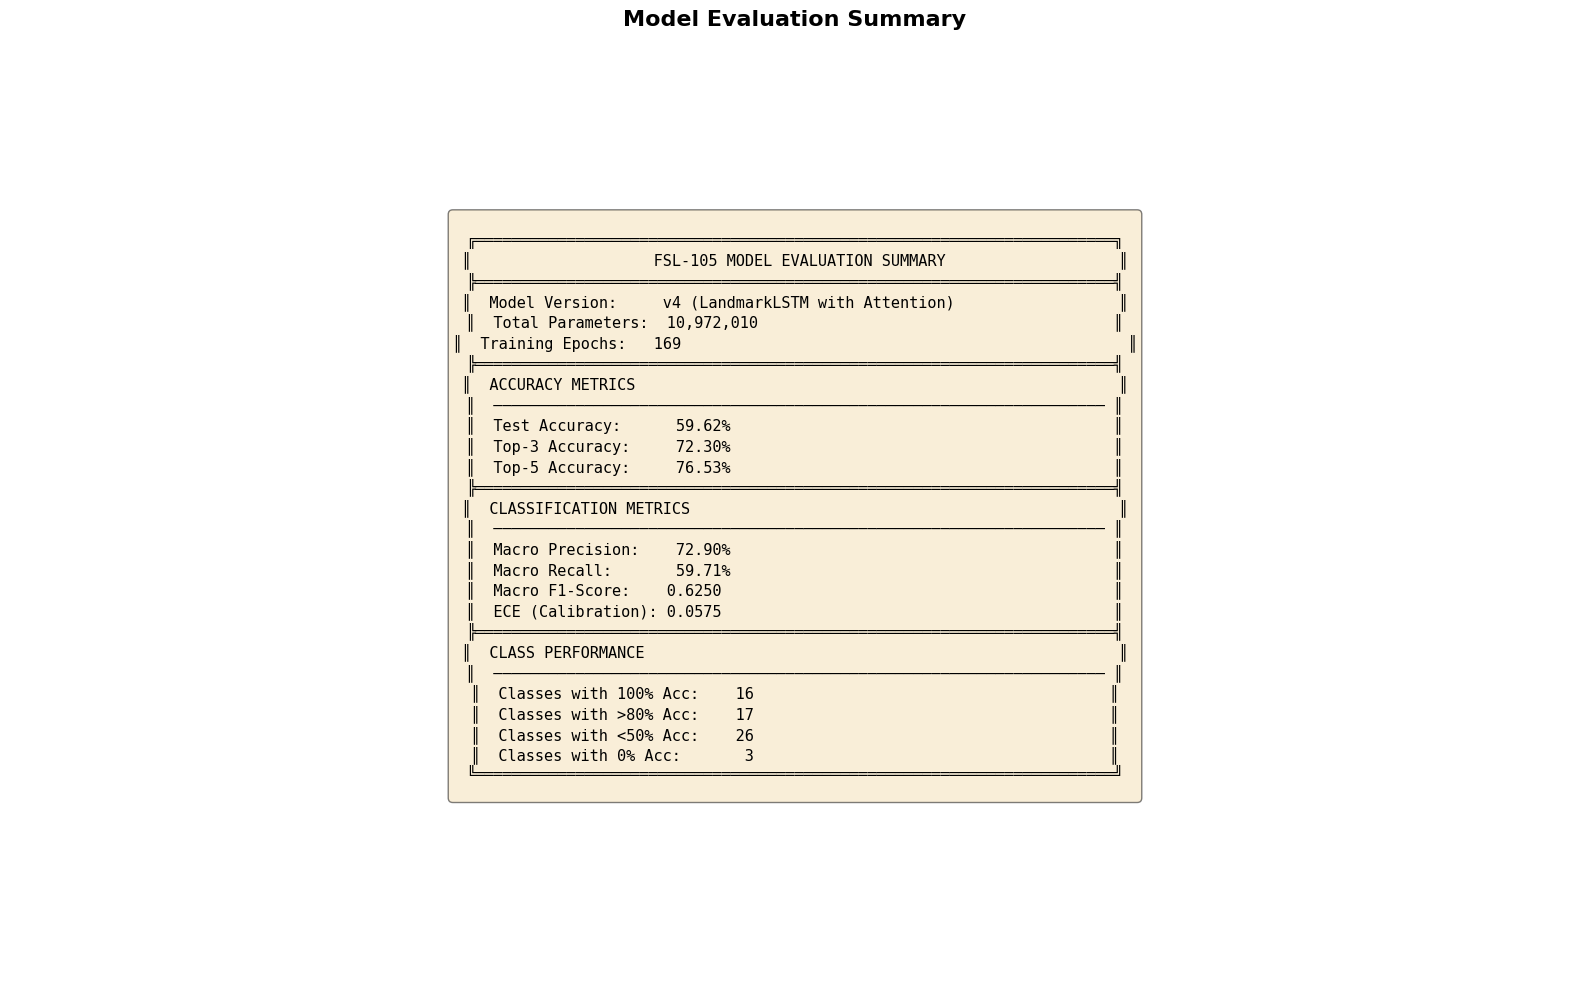


ALL EVALUATION VISUALIZATIONS SAVED:
  1. confusion_matrix_full.png
  2. confusion_matrix_normalized.png
  3. per_class_metrics.png
  4. confidence_analysis.png
  5. confused_pairs.png
  6. tsne_embeddings.png
  7. training_dynamics.png
  8. evaluation_summary.png
  9. classification_report.txt


In [17]:
# ============================================================================
# 7. CLASSIFICATION REPORT & FINAL SUMMARY
# ============================================================================

# Print full classification report
print("\n" + "="*80)
print("FULL CLASSIFICATION REPORT")
print("="*80)
report = classification_report(all_labels, all_preds, target_names=class_names, zero_division=0)
print(report)

# Save report to file
with open('classification_report.txt', 'w') as f:
    f.write("FSL-105 MODEL EVALUATION REPORT\n")
    f.write("="*80 + "\n\n")
    f.write(f"Model Version: v4 (Final)\n")
    f.write(f"Date: {pd.Timestamp.now()}\n\n")
    f.write(f"OVERALL METRICS:\n")
    f.write(f"  Test Accuracy: {accuracy:.2f}%\n")
    f.write(f"  Top-3 Accuracy: {top3_acc:.2f}%\n")
    f.write(f"  Top-5 Accuracy: {top5_acc:.2f}%\n")
    f.write(f"  Macro Precision: {precision.mean()*100:.2f}%\n")
    f.write(f"  Macro Recall: {recall.mean()*100:.2f}%\n")
    f.write(f"  Macro F1-Score: {f1.mean():.4f}\n")
    f.write(f"  Expected Calibration Error: {ece:.4f}\n\n")
    f.write("DETAILED CLASSIFICATION REPORT:\n")
    f.write("-"*80 + "\n")
    f.write(report)

print("\n✓ Classification report saved to 'classification_report.txt'")

# Create final summary figure
fig = plt.figure(figsize=(16, 10))

# Summary text box
summary_text = f"""
╔══════════════════════════════════════════════════════════════════════╗
║                    FSL-105 MODEL EVALUATION SUMMARY                   ║
╠══════════════════════════════════════════════════════════════════════╣
║  Model Version:     v4 (LandmarkLSTM with Attention)                  ║
║  Total Parameters:  {sum(p.numel() for p in model.parameters()):,}                                       ║
║  Training Epochs:   {len(train_losses)}                                                 ║
╠══════════════════════════════════════════════════════════════════════╣
║  ACCURACY METRICS                                                     ║
║  ─────────────────────────────────────────────────────────────────── ║
║  Test Accuracy:     {accuracy:>6.2f}%                                          ║
║  Top-3 Accuracy:    {top3_acc:>6.2f}%                                          ║
║  Top-5 Accuracy:    {top5_acc:>6.2f}%                                          ║
╠══════════════════════════════════════════════════════════════════════╣
║  CLASSIFICATION METRICS                                               ║
║  ─────────────────────────────────────────────────────────────────── ║
║  Macro Precision:   {precision.mean()*100:>6.2f}%                                          ║
║  Macro Recall:      {recall.mean()*100:>6.2f}%                                          ║
║  Macro F1-Score:    {f1.mean():>6.4f}                                           ║
║  ECE (Calibration): {ece:>6.4f}                                           ║
╠══════════════════════════════════════════════════════════════════════╣
║  CLASS PERFORMANCE                                                    ║
║  ─────────────────────────────────────────────────────────────────── ║
║  Classes with 100% Acc:   {(per_class_acc == 100).sum():>3}                                       ║
║  Classes with >80% Acc:   {(per_class_acc >= 80).sum():>3}                                       ║
║  Classes with <50% Acc:   {(per_class_acc < 50).sum():>3}                                       ║
║  Classes with 0% Acc:     {(per_class_acc == 0).sum():>3}                                       ║
╚══════════════════════════════════════════════════════════════════════╝
"""

plt.text(0.5, 0.5, summary_text, transform=plt.gca().transAxes, 
         fontsize=11, verticalalignment='center', horizontalalignment='center',
         fontfamily='monospace', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
plt.axis('off')
plt.title('Model Evaluation Summary', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('evaluation_summary.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "="*70)
print("ALL EVALUATION VISUALIZATIONS SAVED:")
print("="*70)
print("  1. confusion_matrix_full.png")
print("  2. confusion_matrix_normalized.png")
print("  3. per_class_metrics.png")
print("  4. confidence_analysis.png")
print("  5. confused_pairs.png")
print("  6. tsne_embeddings.png")
print("  7. training_dynamics.png")
print("  8. evaluation_summary.png")
print("  9. classification_report.txt")
print("="*70)